# Full script to analyse Food and You survey data in relation to Census data

Import all relevant libraries here 

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.stats.proportion as smp
from matplotlib.backends.backend_pdf import PdfPages
from ipywidgets import interact

Define where in your local repository data can be found

In [13]:
census_path = '/users/mihaelanemes/Desktop/s2ds/data/Data/microdata_census2011_wales.xlsx'
survey_guide_path = '/users/mihaelanemes/Desktop/s2ds/data/Data/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'
survey_path = '/users/mihaelanemes/Desktop/s2ds/data/Data//Food+and+You+Waves+1-5+Data (3).csv'

#survey_path = 'insert_your_own_path/Food+and+You+Waves+1-5+Data (3).csv'
#survey_guide_path = 'insert_your_own_path/withGuide_Food+and+You+Waves+1-5+Data+User+Guide.xlsx'
#census_path = 'insert_your_own_path/microdata_census2011_wales.xlsx'

## Custom dictionaries 

Dictionaries to rename values and variables to comprehensible and meaningful names

    questions_dict - applies to all questions
    answers_dict - applies to all answers
    answers_dict_high_risk - applies to the relevant questions and marks up the associated high risk values (useful for plotting questions so that only the info of interest is visualised )

In [60]:
# Create a dictionary of question names
questions_dict = pd.read_excel(survey_guide_path, 'Variables')
questions_dict = pd.Series(questions_dict.Label.values, index=questions_dict.Variable).to_dict()

# remove extra text from questions e.g (D) not possible


# Create a nested dictionary of answer names
answers_dict = pd.read_excel(survey_guide_path, 'Values')
answers_dict['Label'] = (answers_dict['Label']
                         .replace({'Wave 1':2010, 'Wave 2':2012, 'Wave 3':2014, 'Wave 4':2016, 'Wave 5':2018})
                         .replace({'Married/Civil Partnership/Living with Partner':'Married/Partnership'})
                         .replace({'Single/Widowed/Divorced/Separated/Other':'Single/Other'}))
answers_dict = answers_dict.fillna(method='ffill')
answers_dict = answers_dict.groupby('Variable')[['Vlue', 'Label']].apply(lambda g: dict(g.values)).to_dict()
answers_dict['wimd_2014_quintile'] = {1: 1, 2: 2, # 1 is most deprived
                                      3: 3, 4: 4, 5: 5, # 5 is least deprived
                                      -8: "Don't know", -1:'Not applicable'}
answers_dict['hhdinc'] = {1: '£10,399 or less', 2: '£10,400 - £25,999', 3: '£26,000 - £51,999', 4:'£52,000 or more',
                          -9:'Refused', -8: "Don't know", -1:'Not applicable'}

### ALLL questions_of_interest = ['bpoison', 'Q4_26b', 'Q4_19b', 'Q4_1_5_comb', 'eatoutev', 'fdsecst', 'sanspray',
###                        'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'safemeat10', 'Q4_2610',
###                        'q4_27_4_slice', 'Q4_27c', 'Q4_28b8', 'q2_14s10a_dv', 'q2_14su8b_dv', 'q2_14su7a_dv',
###                        'q2_14s13_dv', 'EatOut1', 'EatOut2', 'EatOut3' ]

# Define questions of interest
questions_of_interest = ['bpoison', 'Q4_1_5_comb', 'eatoutev', 'q4_1_6', 'Q4_1_5_comb', 'Q4_19b', 'fdsecst',
                         'sanspray', 'Q4_26b', 'q4_1_8a', 'q4_1_11', 'dq4_1bc', 'Q4_143', 'safemeat10',
                         'Q4_2610', 'q4_27_4_slice', 'Q4_27c', 'Q4_28b8', 'q2_14s10a_dv', 'q2_14su8b_dv',
                         'q2_14su7a_dv', 'q2_14s13_dv', 'EatOut1', 'EatOut2', 'EatOut3']

# Define high risk answers to questions of interest (in same order)
high_risk_answers = [1,1,1,4,4,4,4,1,1,1,1,2,1,1,1,5,2,1,4,4,4,4,1,1,1]
question_risk_aswers = pd.DataFrame(
    {'question': questions_of_interest,
     'high_risk_answer': high_risk_answers
    })

#q2_14s10a_dv, q2_14su8b_dv, q2_14su7a_dv, q2_14s13_dv: multiple high_risk answers: 1-7
#EatOut3 problem is that the question with its answers is doubleD!!

## Custom functions for data visualization

Custom function for creating grouped barplots of the variables of interest and save the output

In [61]:
def custom_barplots(dataset, # dataframe
                    groupping, # string
                    variables_of_interest, # list of string(s)
                    title_of_output='example.pdf', # string
                    barwidth=0.5, myspacingy=0.09, myspacingx=8, myfontsize=17,
                    high_risk_option = 'no', interactivity = 'no'):
    
    pdf = PdfPages(title_of_output)
    figures = []
    
    row = 0
    
    for variable in variables_of_interest:

        temp = dataset.copy()

        # Group according to the features of interest and calculate the % of answer types for the main target feature
        temp = temp.groupby([groupping, variable])[variable].agg(['count'])
        temp['total'] = temp.groupby(groupping)['count'].transform('sum')
        lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
        temp['CI_prop_upper'] = upper
        temp['CI_prop_lower'] = lower
        temp[variable + ' (%)'] = temp['count'] / temp['total'] * 100
        temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
        temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
        temp['abs_err'] = temp[variable + ' (%)'] - temp['CI_perc_lower']
        temp.reset_index(inplace=True) # To 'undo' the grouping
        temp = temp.round(1)
        temp
        
        high_risk_option_chosen = high_risk_option
        if high_risk_option_chosen == 'yes':
            high_risk_answer = question_risk_aswers.loc[row, 'high_risk_answer']
            temp = temp[temp[variable] == high_risk_answer]
            row += 1
    
        # Recode the answers of those variables we want to use to stratify the population
        answers_to_rename = [variable]
        temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict)

        abs_err = temp.pivot(index=variable, columns=groupping, values='abs_err')

        g = temp.pivot(index=variable, columns=groupping, values=variable+' (%)')\
        .plot(kind='barh', xerr=abs_err, width=barwidth, figsize=(3,10))
        for item in ([g.title, g.xaxis.label, g.yaxis.label] + g.get_xticklabels() + g.get_yticklabels()):
            item.set_fontsize(20)
        plt.title(questions_dict.get(variable), x =0,  fontsize = 20)
        plt.xlabel(variable + ' (%)')
        plt.ylabel('')
        plt.xlim(0, max(temp[variable +' (%)'] + 15))
        g.legend(loc='center left', bbox_to_anchor=(1.5, 0.75), fontsize=16)
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        g.spines['left'].set_visible(False)

        # To plot the % number
        for p in g.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            g.annotate('{:}%'.format(width), (x + width + myspacingx, y + myspacingy), fontsize = myfontsize)
            # play with fontsize, depending on graph

        #plt.show()
        
        figures += [g.figure]
    
    if interactivity == 'no':
        for figure in figures:
            pdf.savefig(figure, bbox_inches='tight') # output file is saved in the same folder as this notebook
        pdf.close()

Custom functions for creating temporal line plots

In [55]:
# The following function specifies the % number on top and the count number below.
def custom_lineplots(x,y,z, **kwargs):
    ax = sns.lineplot(x,y,**kwargs)
    for i in range(len(x)):
        ax.annotate(str(y.values[i]) + '%', xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')
    for i in range(len(x)):
        ax.annotate('n=' + str(z.values[i]), xy=(x.values[i], y.values[i]),fontsize=10,
                    xytext = (0,-10), textcoords="offset points",
                color=kwargs.get("color","k"), 
                va='center', ha='center')

# Wrapper function for plt.errorbar
def errorbar(x, y, low, high,  color, **kws):
    plt.errorbar(x, y, (y - low, high - y), color=color)

# Complete lineplot function
def custom_lineplots_complete(dataset, # dataframe
                              variables_of_interest, # list of string(s)
                              title_of_output): # string
    
    pdf = PdfPages(title_of_output)
    figures = []

    for variable in variables_of_interest:
    
        temp = dataset[[variable] + ['country_dv', 'surveyyear']]

        # Group according to the features of interest and calculate the % of answer types for the main target feature
        temp = temp.groupby(['country_dv','surveyyear', variable])[variable].agg(['count'])
        temp['total'] = temp.groupby(['country_dv','surveyyear'])['count'].transform('sum')
        lower, upper = smp.proportion_confint (temp['count'], temp['total'], alpha=0.05, method='normal')
        temp['CI_prop_upper'] = upper
        temp['CI_prop_lower'] = lower
        temp[variable + ' (%)'] = temp['count'] / temp['total'] * 100
        temp['CI_perc_upper'] = temp['CI_prop_upper'] * 100
        temp['CI_perc_lower'] = temp['CI_prop_lower'] * 100
        temp.reset_index(inplace=True) # To 'undo' the grouping
        temp = temp.round(1)
       # Recode the answers of those variables we want to use to stratify the population
        answers_to_rename = ['country_dv', variable, 'surveyyear']
        temp[answers_to_rename] = temp[answers_to_rename].replace(answers_dict) # pandas 1.0.3 (or newer) needed for nested replace

        # Plot features of interest from the created 'temp' subset
        g = sns.FacetGrid(temp, col='country_dv', hue=variable, height=4, aspect=1) 
        g.map(errorbar, 'surveyyear', variable + ' (%)', 'CI_perc_lower', 'CI_perc_upper')
        g = (g.map(custom_lineplots, 'surveyyear', variable + ' (%)', 'count')
             .add_legend())
        plt.xlim(2009, 2019)
        g.set_titles('{col_name}', pad = 25)
        plt.subplots_adjust(hspace=0.4, wspace=0.4, top=0.75)
        for ax in g.axes.flatten():
            ax.tick_params(labelbottom=True, labelleft=True)
        plt.figtext(.5,.9, questions_dict.get(variable), fontsize=12, ha='center')

        figures += [g.fig]

    for figure in figures:
        pdf.savefig(figure)
    pdf.close()


## Loading and processing the FSA and Census data 
Can take up to 20 min to fully load the datasets

In [17]:
# Load Food and You survey dataset

survey_full_dataset = pd.read_csv(survey_path)
survey_full_dataset = pd.DataFrame(survey_full_dataset)

# Encode 'Not applicable', 'Refused' and 'Don't know' as NaN
survey_full_dataset = survey_full_dataset.replace([-9, -8, -1, 98], np.nan)
cols_5_NaN = ['q4_1_4', 'q4_1_5a', 'Q4_1_5_comb', 'q4_1_6', 'q4_1_7', 'q4_1_8a', 'q4_1_8b', 'sanspray', 'q4_1_11',
              'q4_1_12', 'q4_1_13', 'q4_1_14', 'q4_1_15', 'q4_1_16', 'q4_1_17', 'q4_1_18', 'q4_1_19']
survey_full_dataset[cols_5_NaN] = survey_full_dataset[cols_5_NaN].replace([5], np.nan)

# group ages according to age bracket: underrep 1, wellrep 2,3&4, overrep 5,6&7
survey_full_dataset['age_dv_grouped'] = (survey_full_dataset['age_dv']
                                         .replace({1:'A', 2:'B', 3:'B', 4:'B', 5:'C', 6:'C', 7:'C'})
                                         .replace({'A':'16-24', 'B':'25-54', 'C':'55+'}))

# Load census 2011 file - includes Wales and England
census_full_dataset = pd.read_excel(census_path)
census_full_dataset = pd.DataFrame(census_full_dataset)

# Keep only Wales data (encoded with no 2 in the 'country' column)
census_full_dataset = census_full_dataset[census_full_dataset.country == 2]

Re-structure census dataset to share colnames and values as in survey dataset

In [71]:
# Create new dataframe where we select only the data for demographics comparison
demographic_variables = ['age', 'marstat', 'religionew', 'sex', 'deprived', 'ecopuk',
                         'health']
census = census_full_dataset[demographic_variables]

# Set -9 values as NaN
census = census.replace (-9, np.nan)

# drop all rows with answers from people below 16 yo
age_out_of_range_index = census[(census['age'] < 16)].index
census.drop(age_out_of_range_index, inplace = True)

# group ages by age group 
census['age_dv'] = pd.cut(census.age, bins = [15,24,34,44,54,64,74,110], labels = [1,2,3,4,5,6,7])

# group ages according to age bracket: underrep 1, wellrep 2,3&4, overrep 5,6&7
census['age_dv_grouped'] = pd.cut(census.age, bins = [15,24,54,110], 
                                  labels = ['16-24','25-54','55+'])


# group marital status
census['marstat2'] = census['marstat'].replace({1:'A', 2:'B', 3:'B', 4:'A', 5:'A', 6:'A'}).replace({'B':1, 'A':2})

# group religion
census['religion_dv'] = (census['religionew']
                         .replace({1:'A', 2:'B', 3:'C', 4:'C', 5:'C', 6:'C', 7:'C', 8:'C',  9: np.nan})
                         .replace({'A':3, 'B':1, 'C':2}))

# group work status
census['workstat2'] = (census['ecopuk']
                       .replace({1:'A', 2:'A', 3:'A', 4:'A', 5:'A', 6:'A', 8:'A', 9:'A', 10:'A', 11:'A', 12:'B', 7:'C', 13:'C', 14:'C', 15:'C', 16:'C'})
                       .replace({'A':1, 'B':2, 'C':3}))

# deprivation index (reverse values)
census['wimd_2014_quintile'] = (census['deprived']
                                .replace({1:'A', 2:'B', 3:'C', 4:'D', 5:'E'})
                                .replace({'A':5, 'B':4, 'C':3, 'D':2, 'E':1}))

# health and sex
census = census.rename(columns={'health': 'Q6_1', 'sex': 'RespSex'})

# remove columns that are duplicates and not in the right format
census = census.drop(columns = ['age', 'marstat', 'religionew', 'ecopuk','deprived'])

Join relevant survey data with the census data in a single dataframe - for demographic variable comparison

In [73]:
# define a list of demographic variables that are to be shared between the datasets
demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 
                         'wimd_2014_quintile', 'age_dv_grouped',
                         'workstat2', 'Q6_1']
# select only the Wales data
demographics_survey_and_census = survey_full_dataset[survey_full_dataset.country_dv.eq(2)] # Select Wales
demographics_survey_and_census = demographics_survey_and_census[demographic_variables]

# create new column to identify which rows come from survey and which from census
demographics_survey_and_census['source'] = 'survey'
census['source'] = 'census'

# add together the two dataframes 
demographics_survey_and_census = pd.concat([demographics_survey_and_census, census])


# Visualising the data

Individual .pdf with all plots are saved within the same folder this notebook is saved in

## Individual demographic variables: F&U vs Survey

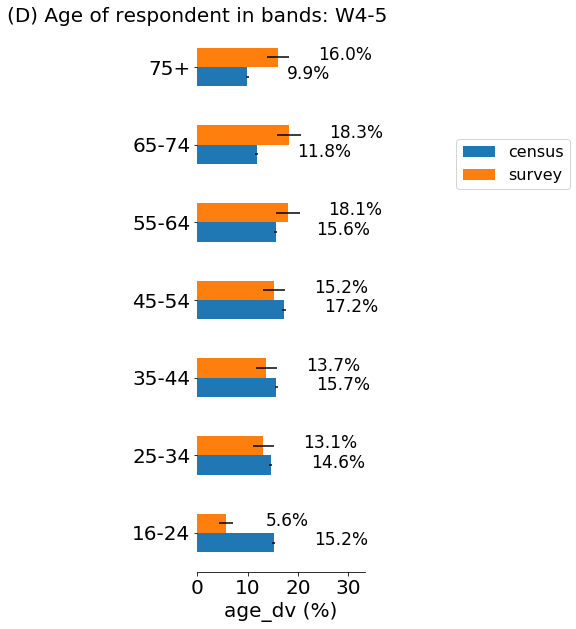

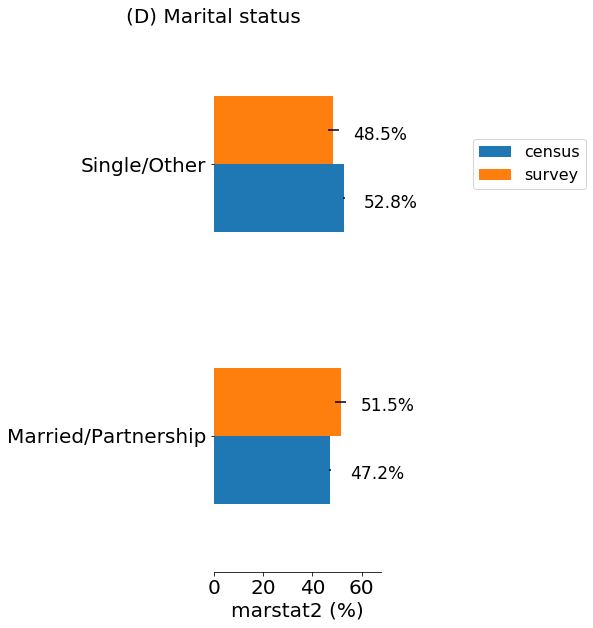

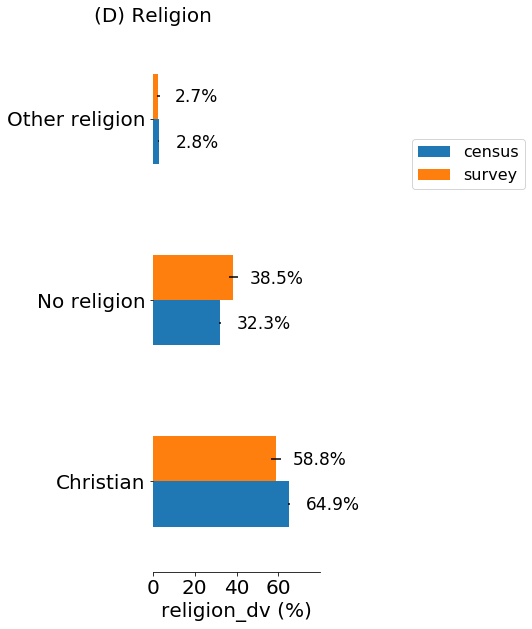

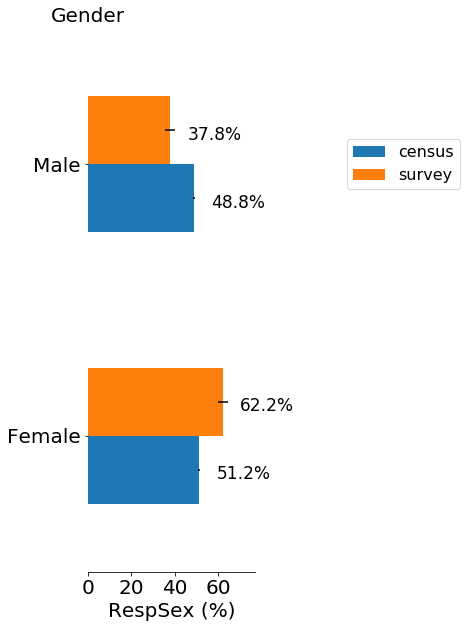

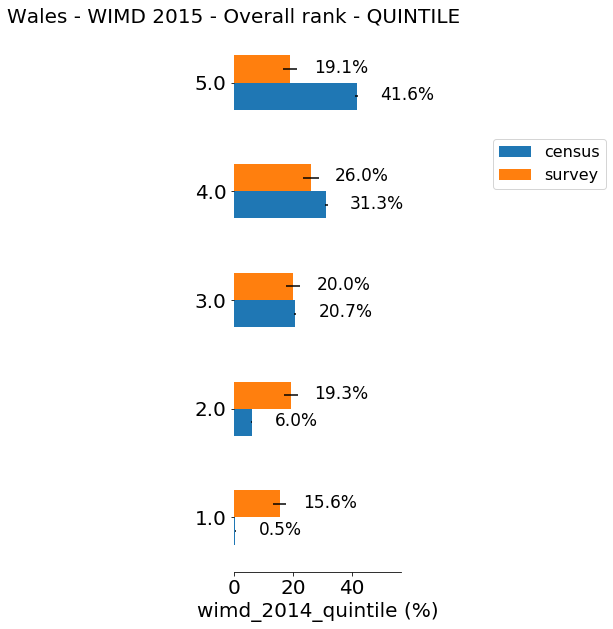

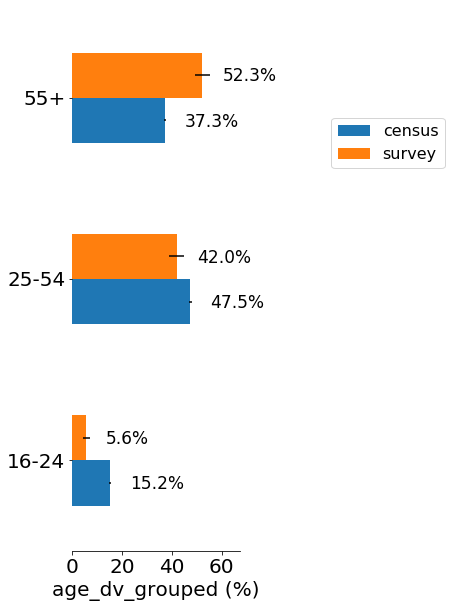

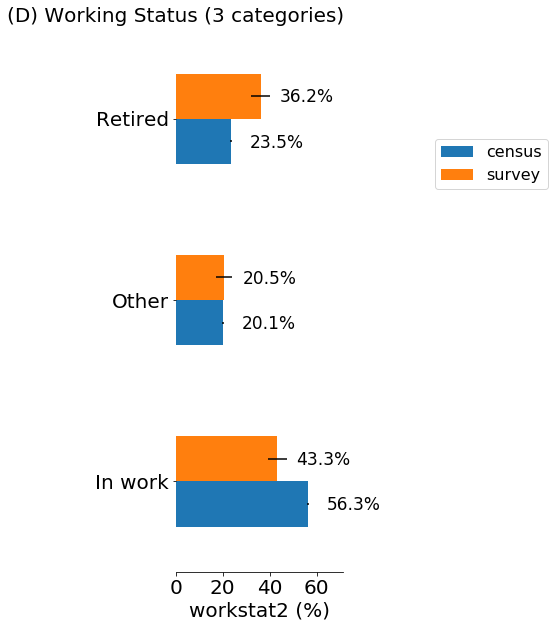

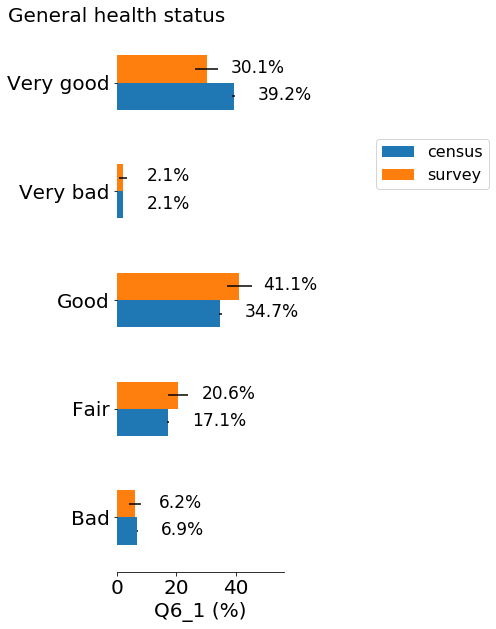

In [74]:
custom_barplots(demographics_survey_and_census,
                'source',
                demographic_variables,
                'survey_vs_census_combined-demographics.pdf')

## Combined demographic variables: F&U vs Survey

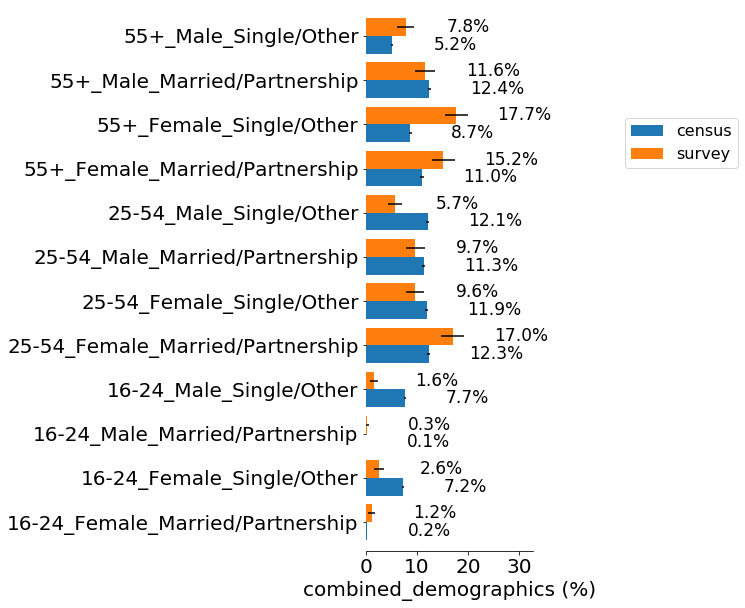

In [75]:
# Output is a single plot. Combination of demographic variables can be defined here

demographics_survey_and_census[demographic_variables] = demographics_survey_and_census[demographic_variables].replace(answers_dict)

demographics_survey_and_census['combined_demographics'] = (demographics_survey_and_census['age_dv_grouped'] + '_' +
                                                           demographics_survey_and_census['RespSex'] + '_' +
                                                           demographics_survey_and_census['marstat2'])

custom_barplots(demographics_survey_and_census,
                'source',
                ['combined_demographics'],
                'survey_vs_census_combined-demographics.pdf',
                barwidth=0.8)

## Demographics by country and year: F&U

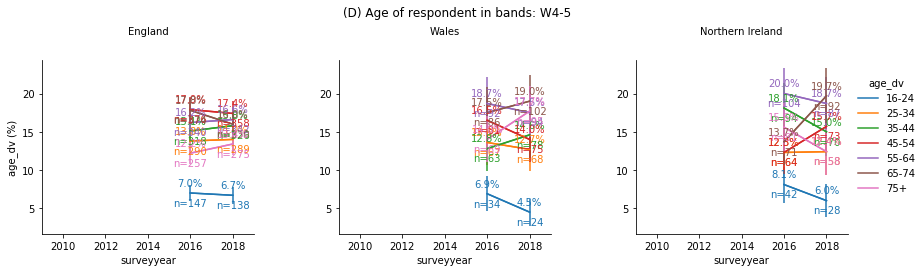

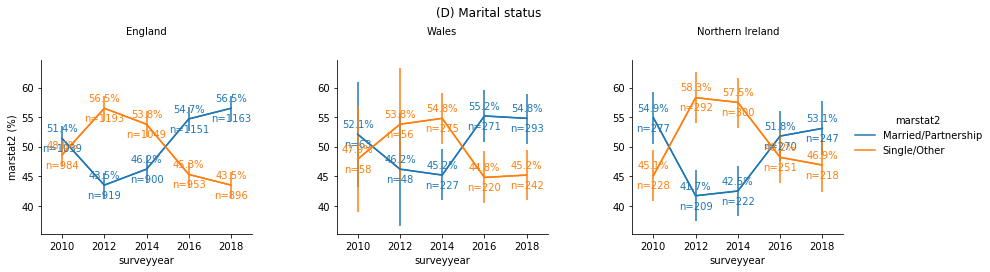

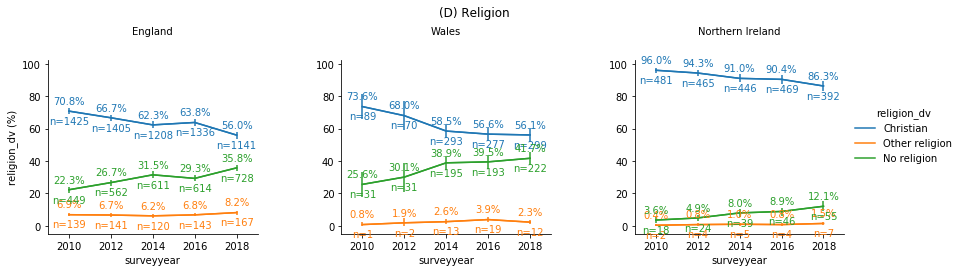

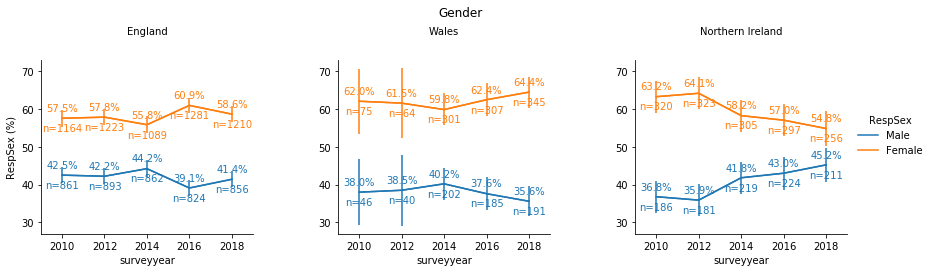

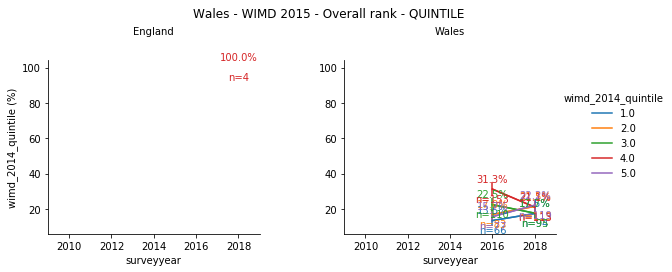

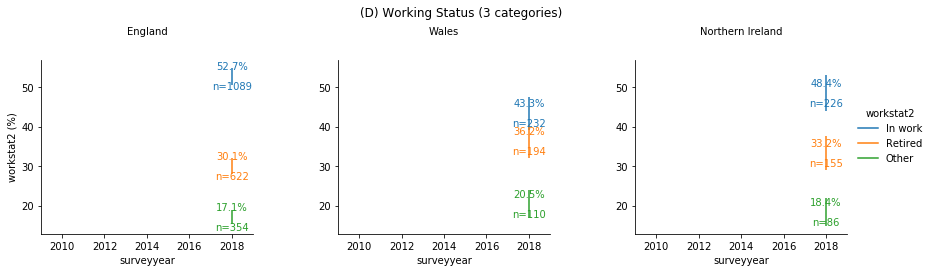

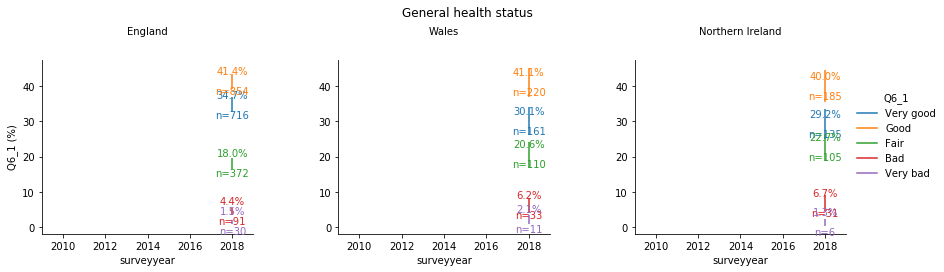

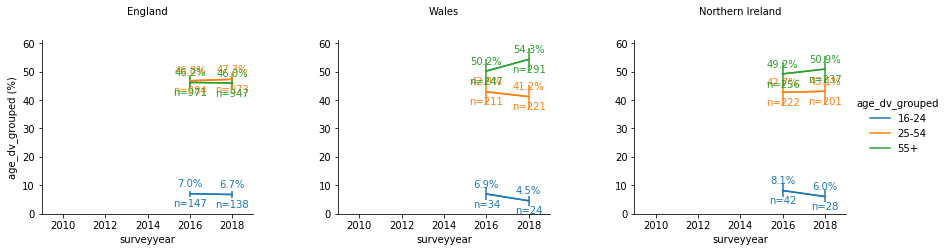

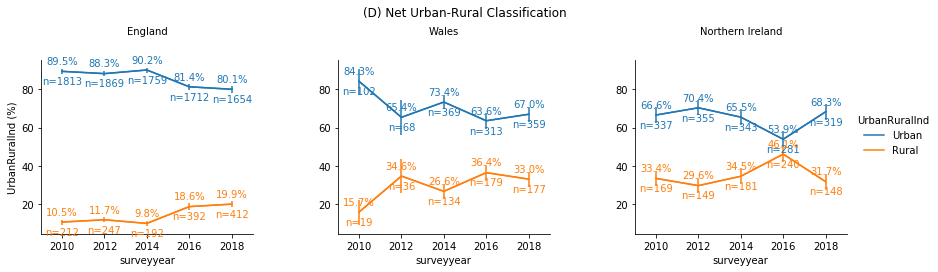

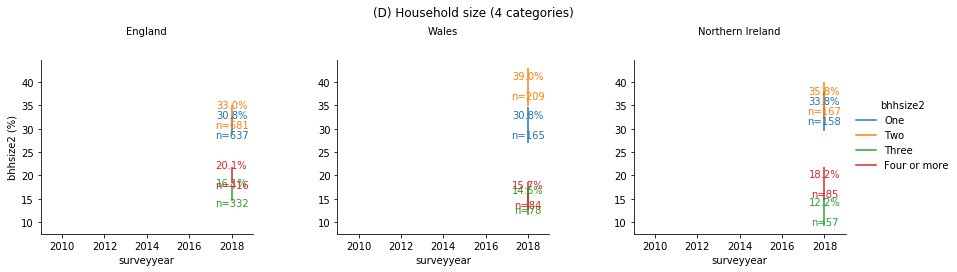

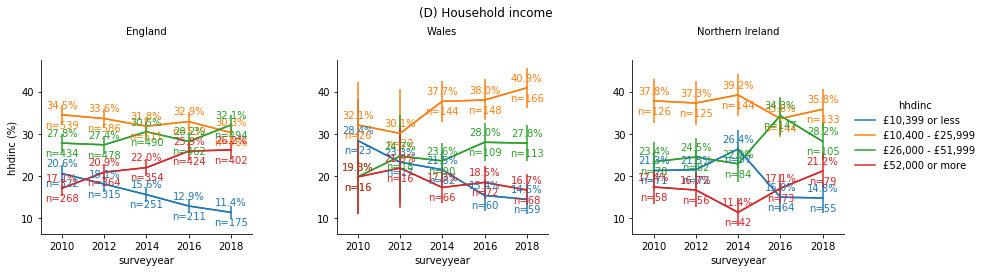

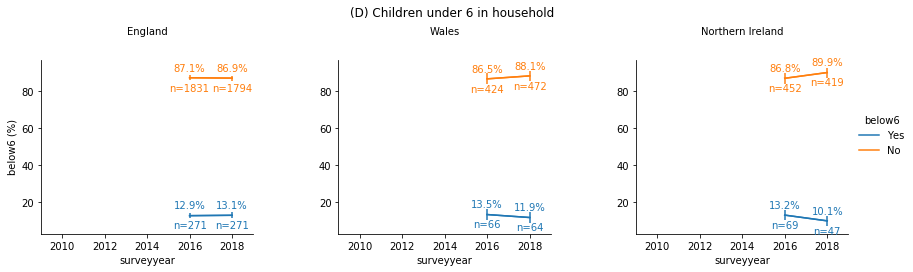

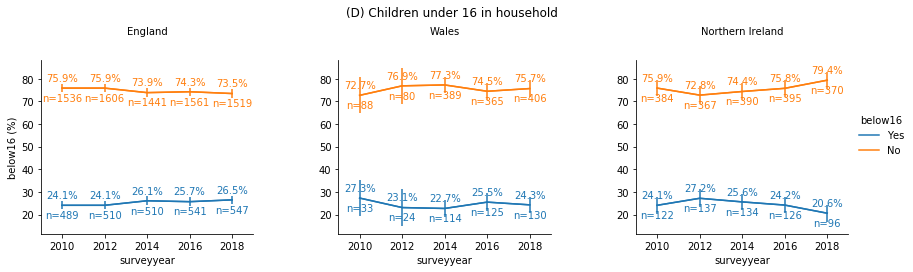

In [77]:
# More extensive list of demographic variables, for use with survey data only

demographic_variables = ['age_dv', 'marstat2', 'religion_dv', 'RespSex', 'wimd_2014_quintile', 'workstat2',
                         'Q6_1', 'age_dv_grouped', 'UrbanRuralInd', 'bhhsize2', 'hhdinc',
                         'below6', 'below16']
custom_lineplots_complete(survey_full_dataset,
                          demographic_variables,
                          'survey_demographics_time.pdf')

## Food risk: F&U

Questions of interest defined in dictionary

### All answers to a given question

/Users/mihaelanemes/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/mihaelanemes/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/mihaelanemes/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.f

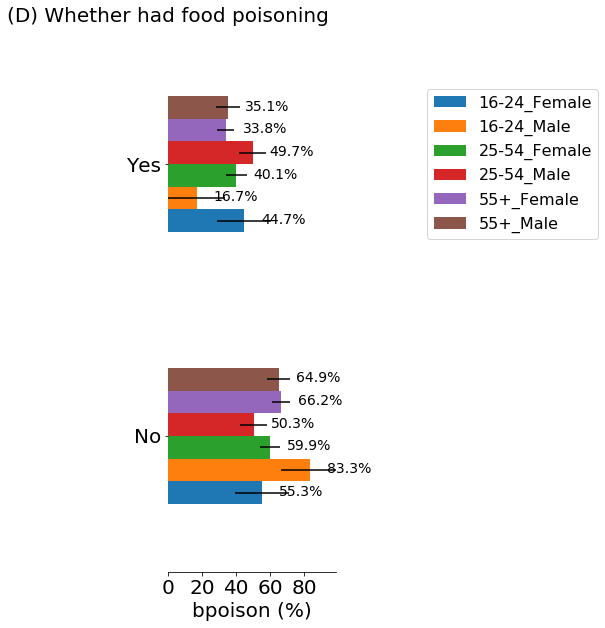

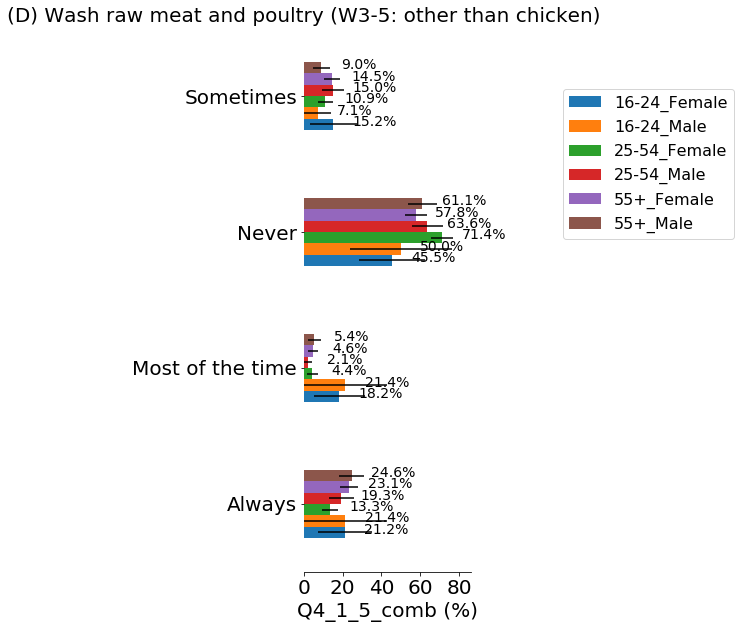

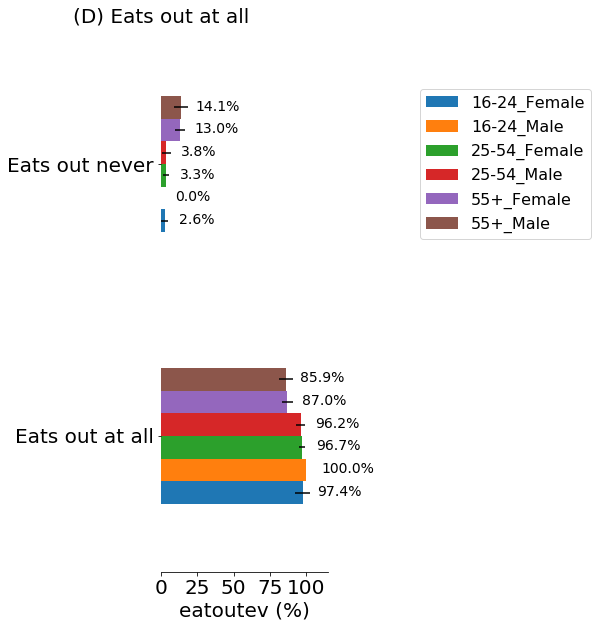

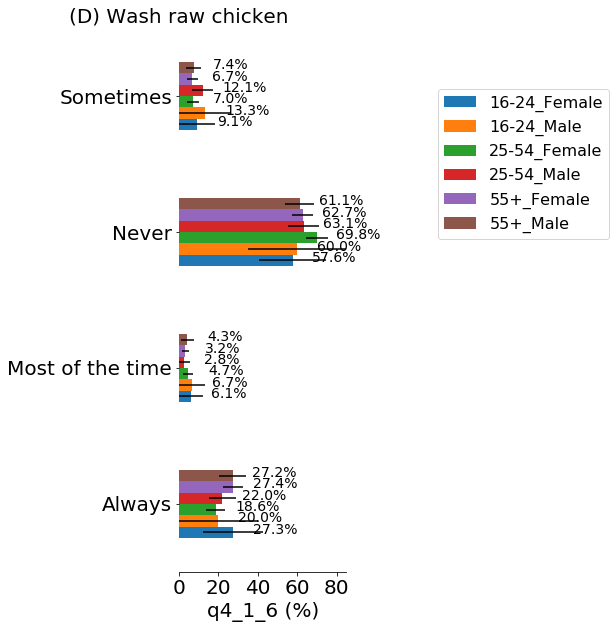

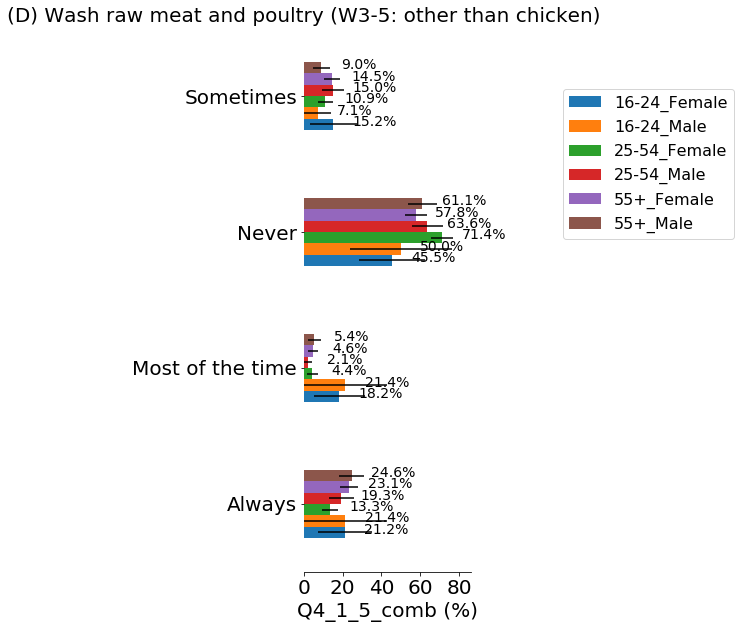

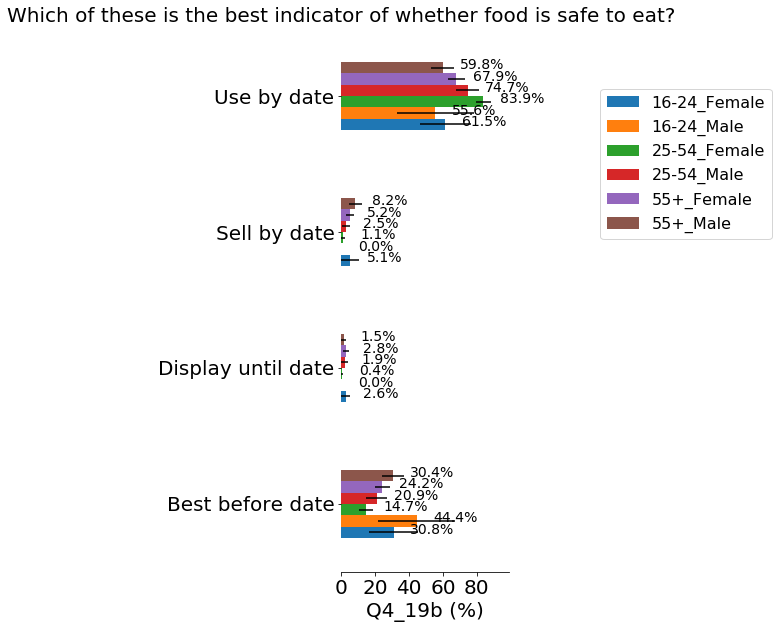

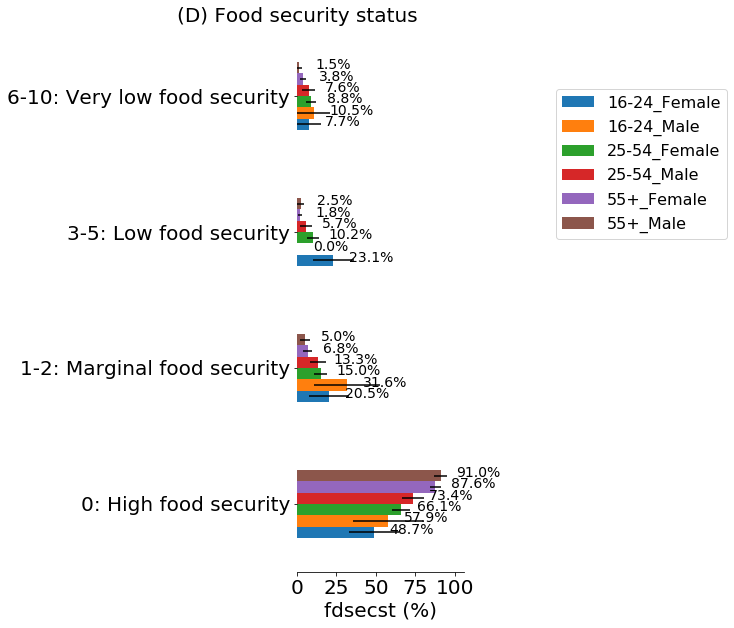

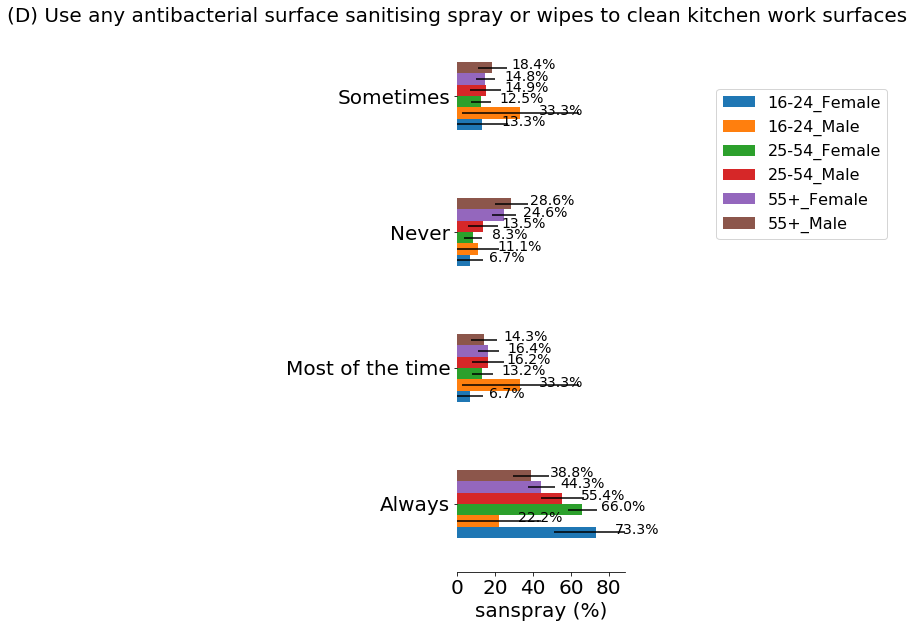

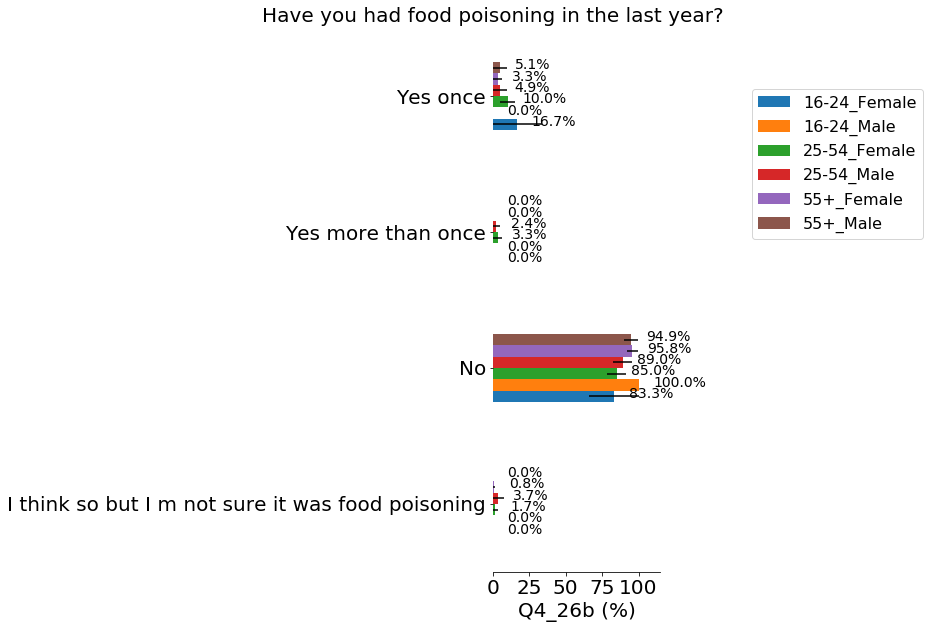

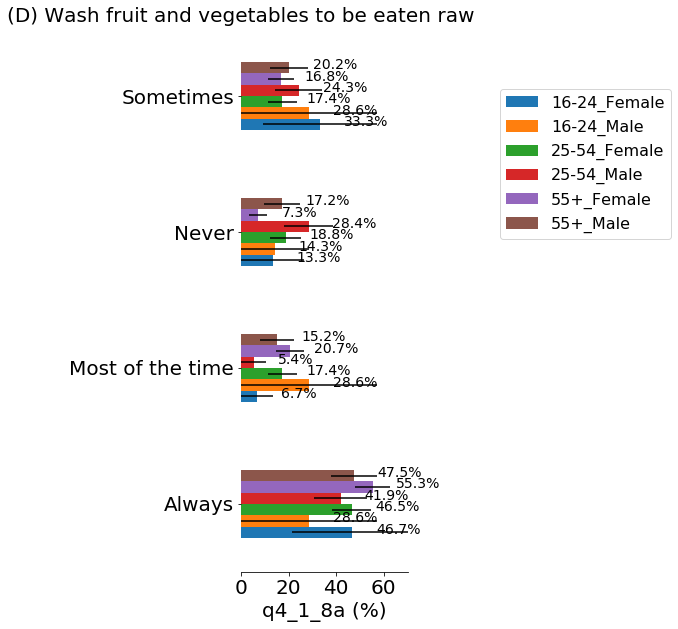

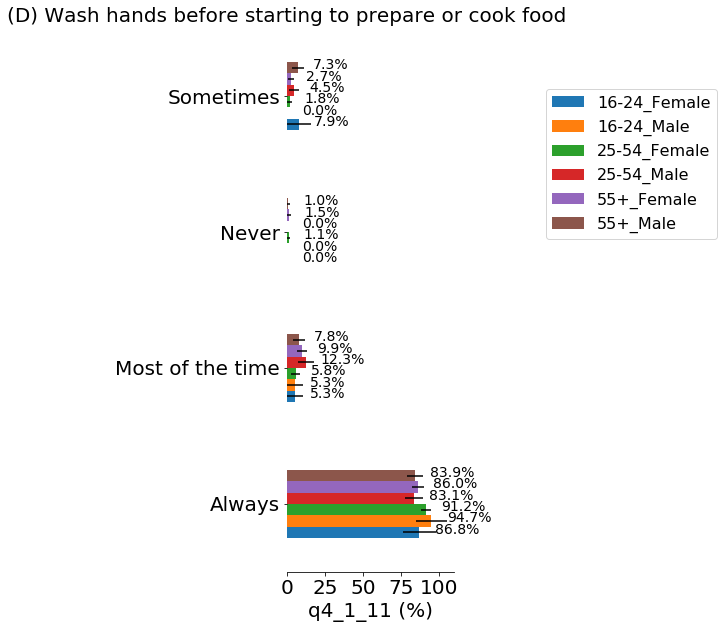

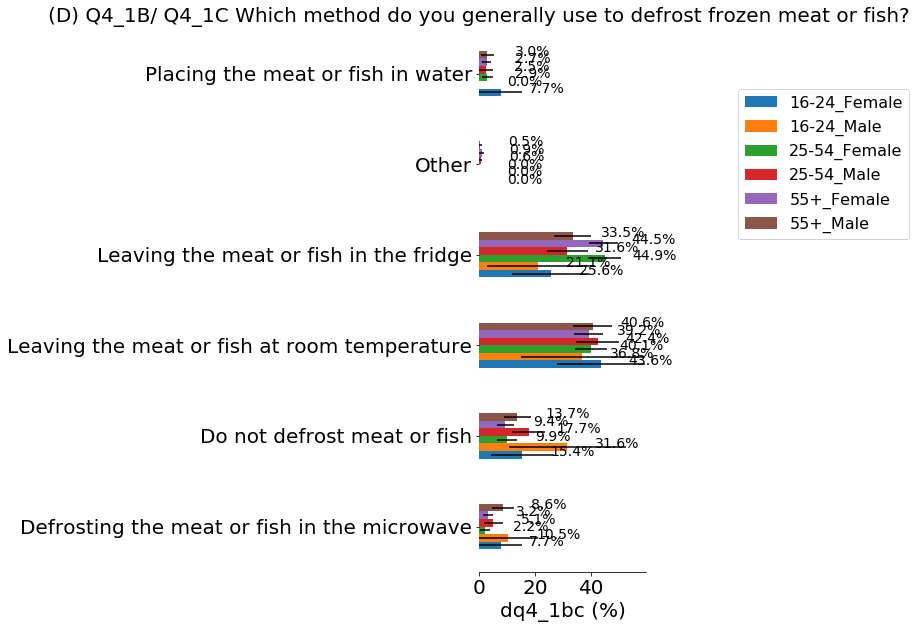

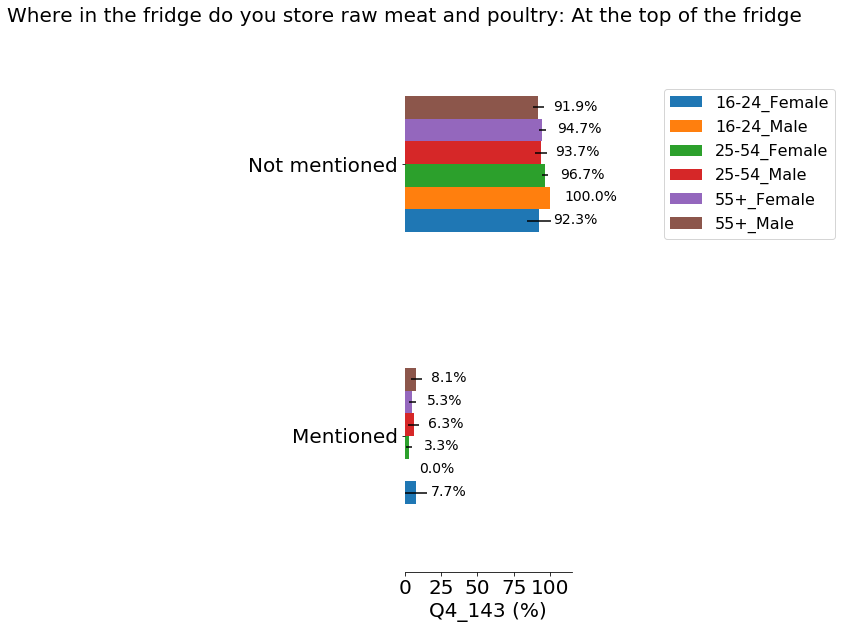

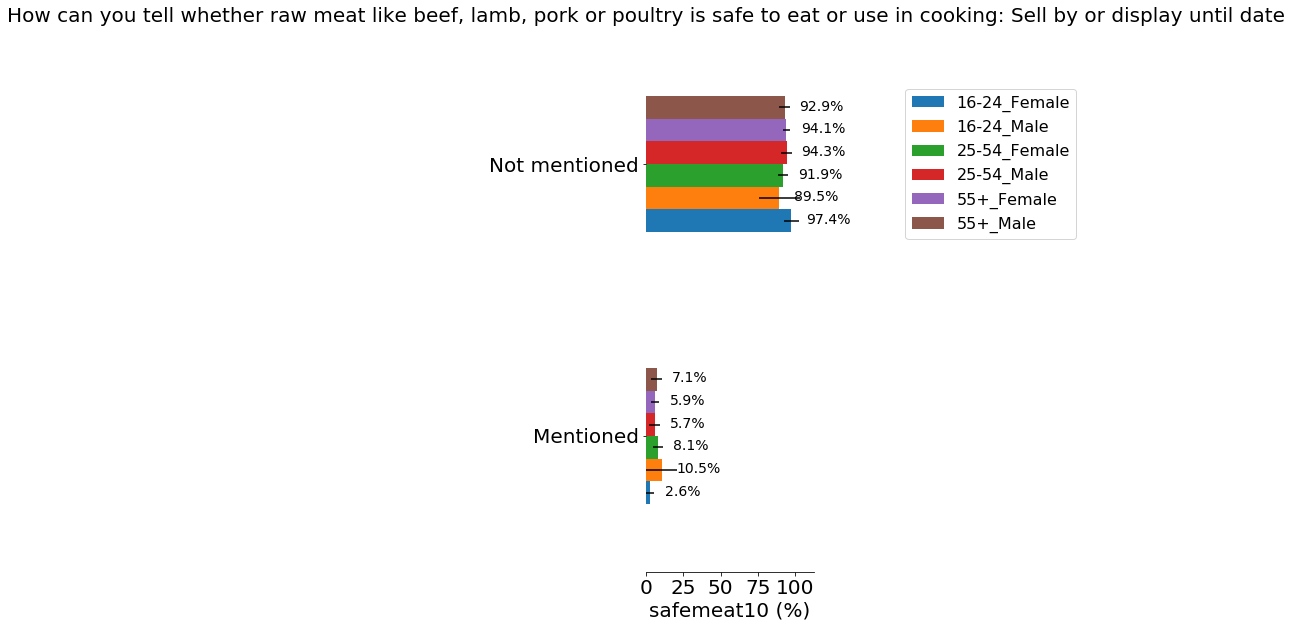

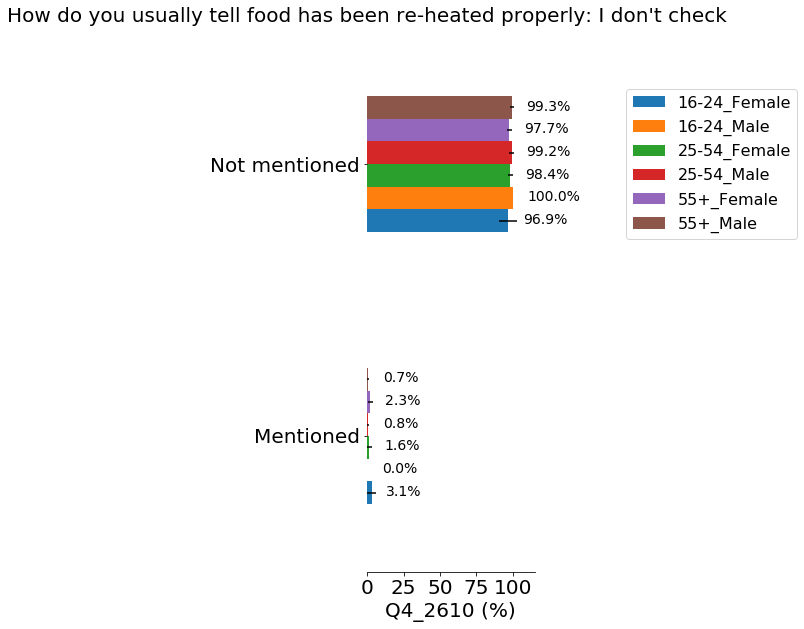

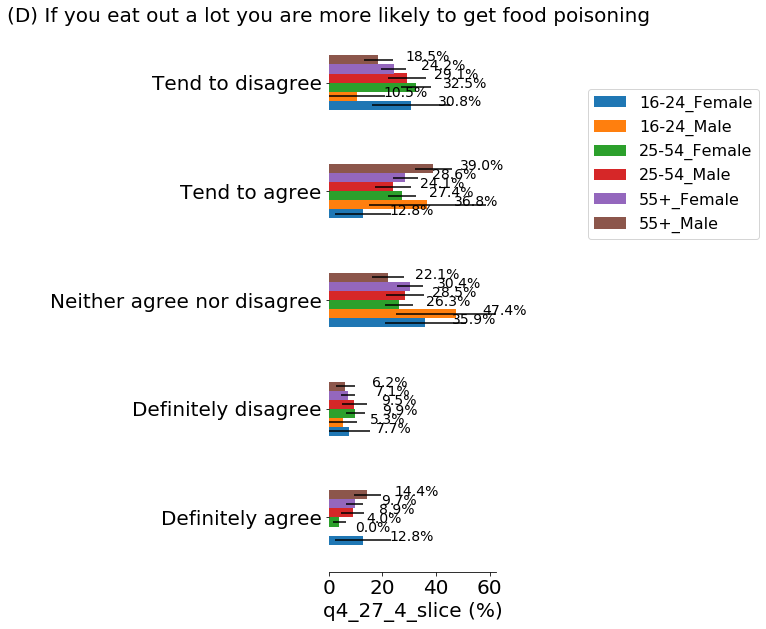

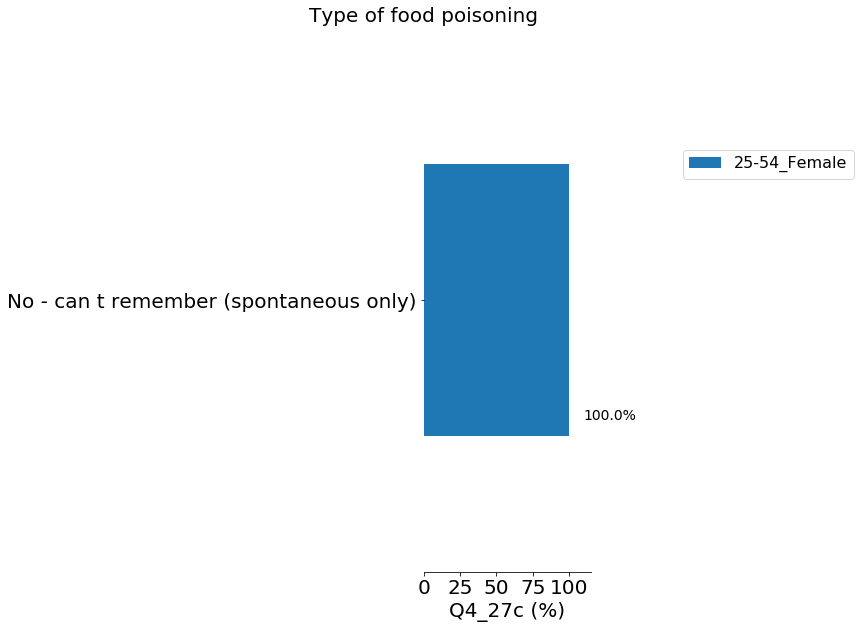

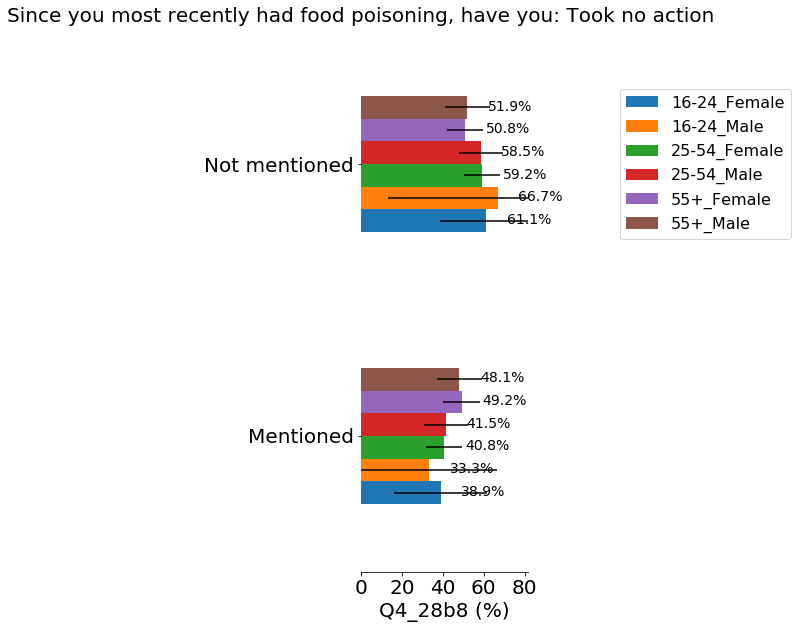

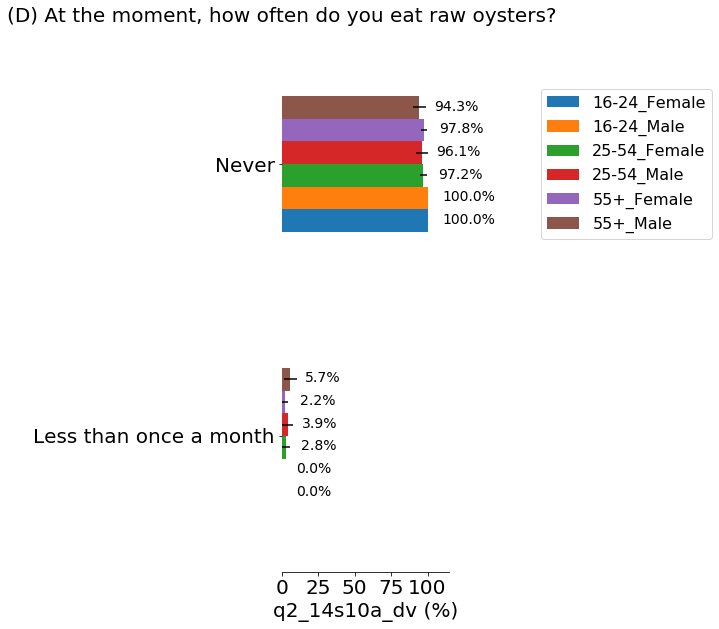

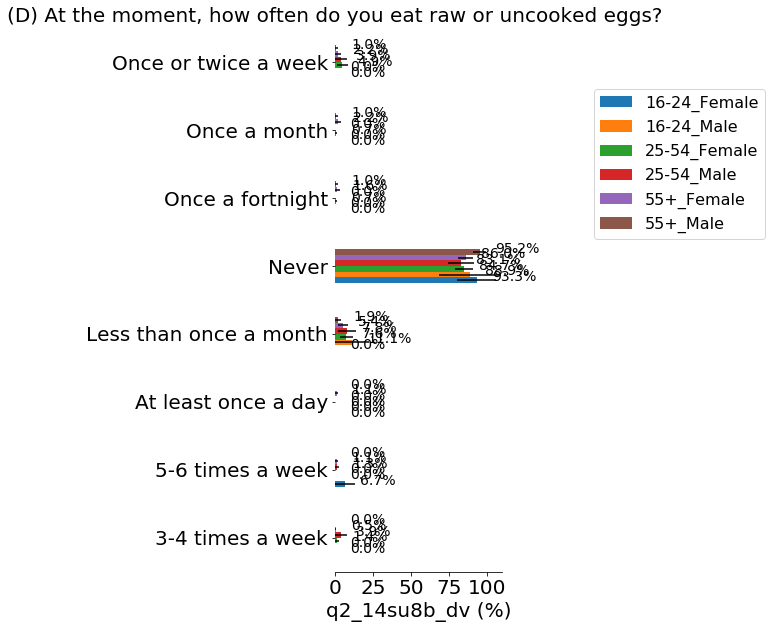

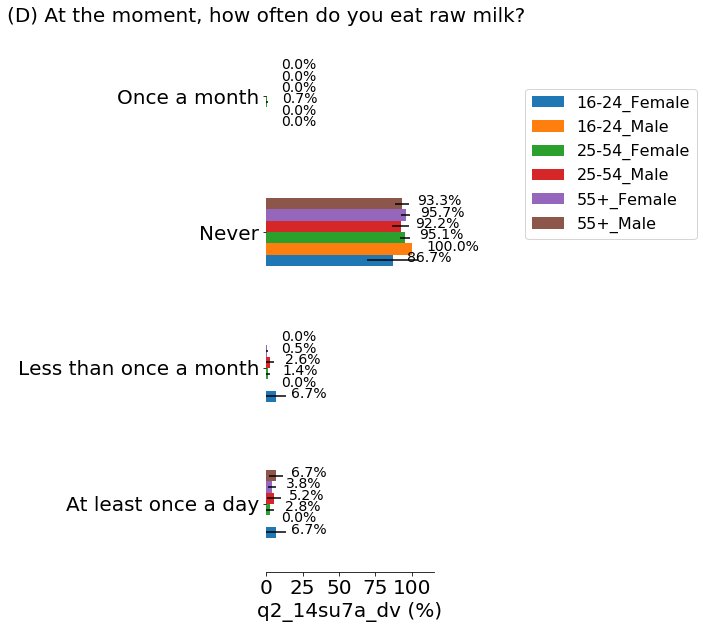

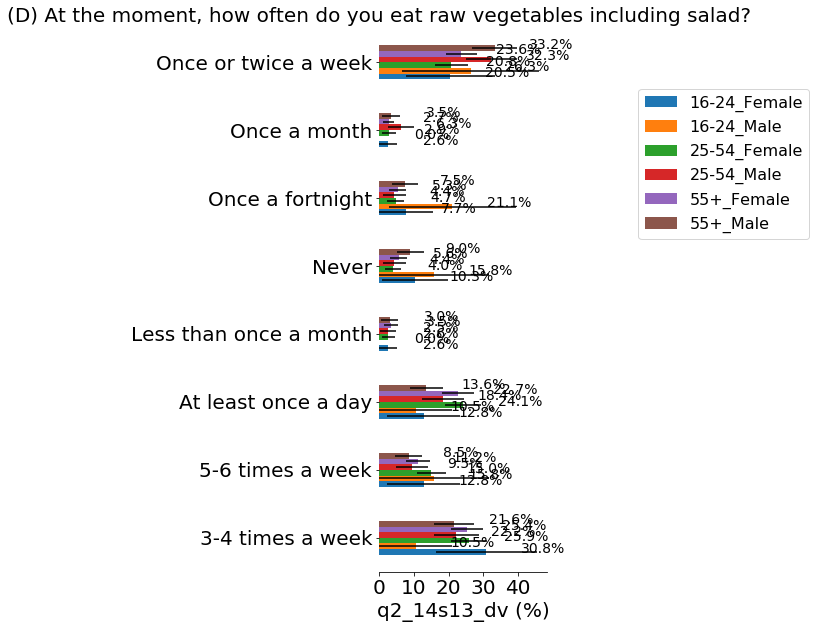

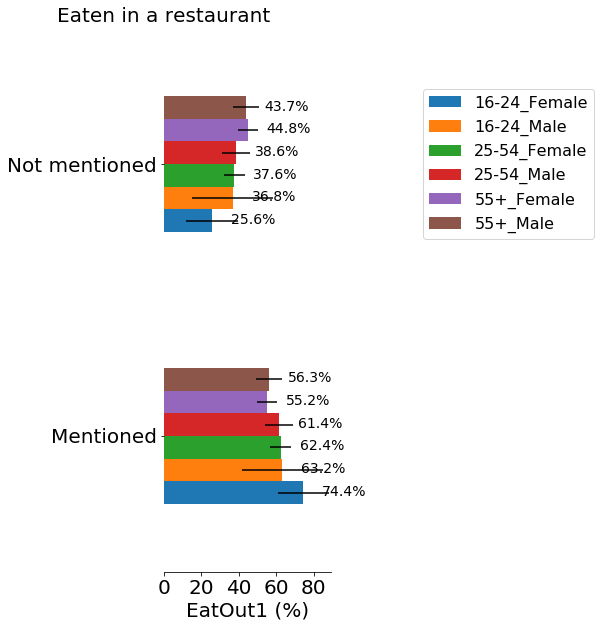

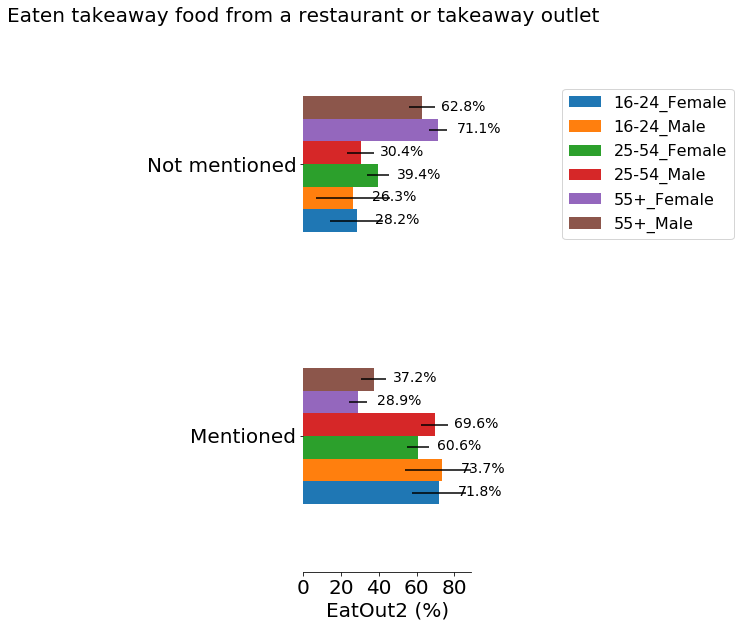

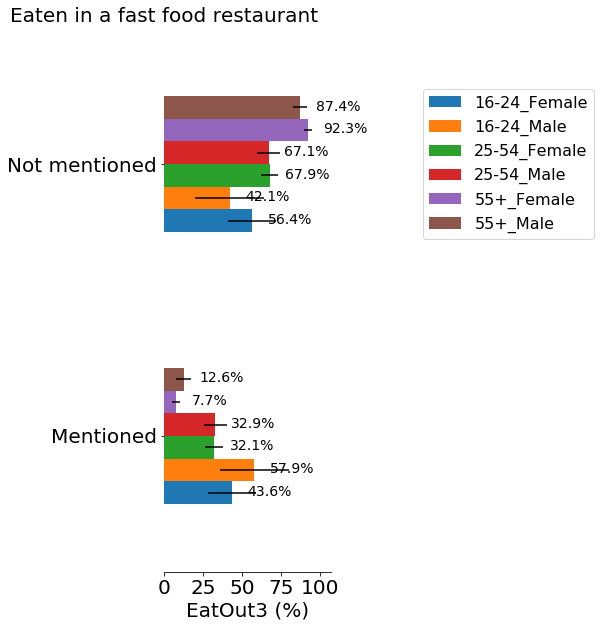

In [80]:
# To consider only the survey answers from wave 4 and 5 only:
waves = [4,5]
survey_subpopulation = survey_full_dataset.loc[survey_full_dataset['surveyyear'].isin(waves)]
survey_subpopulation[demographic_variables] = survey_subpopulation[demographic_variables].replace(answers_dict)

survey_subpopulation['combined_demographics'] = (survey_subpopulation['age_dv_grouped'] + '_' +
                                                survey_subpopulation['RespSex'])

custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(2)],
                'combined_demographics',
                questions_of_interest,
                'foodBehaviour_byDemographics.pdf',
                myspacingy=0.03, myspacingx=10, myfontsize=14)

### Only high risk answers for questions of interest

/Users/mihaelanemes/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


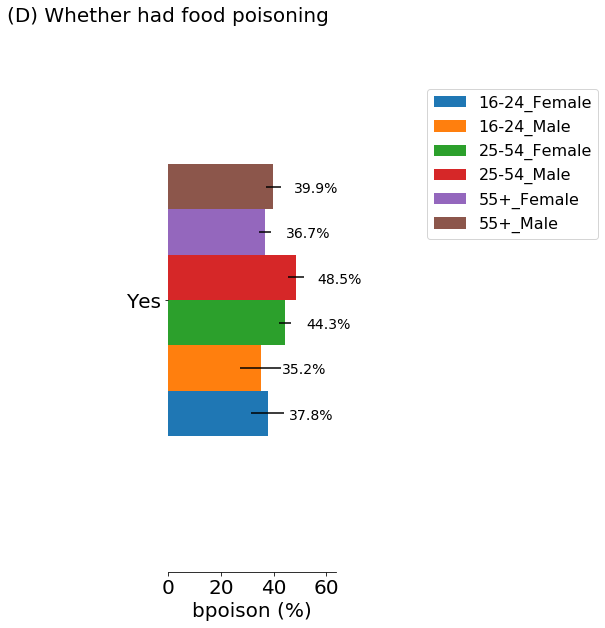

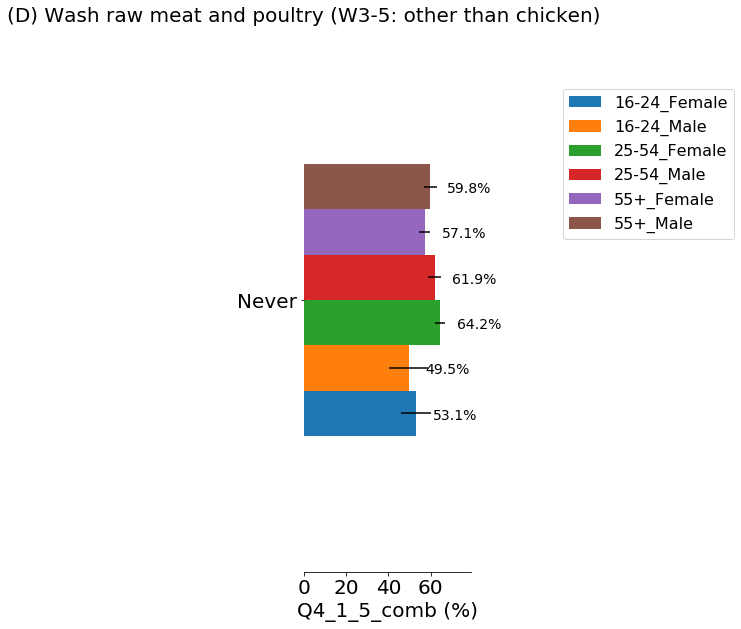

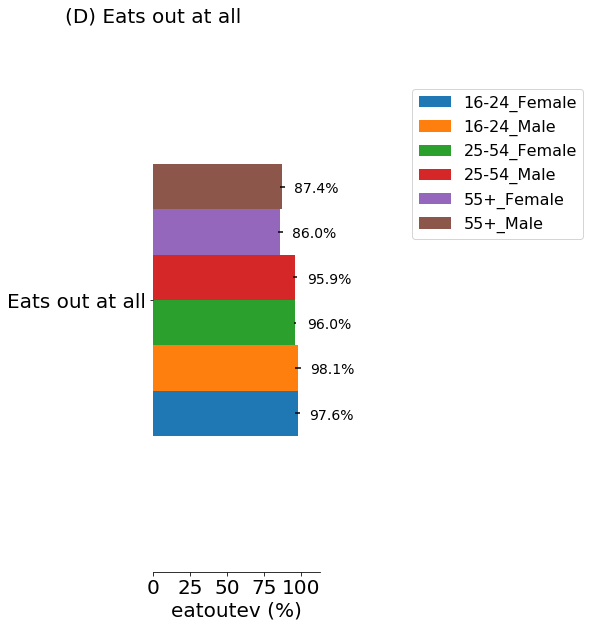

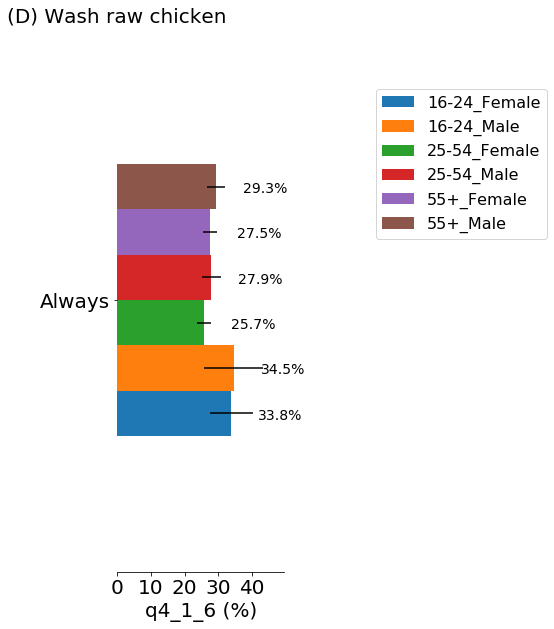

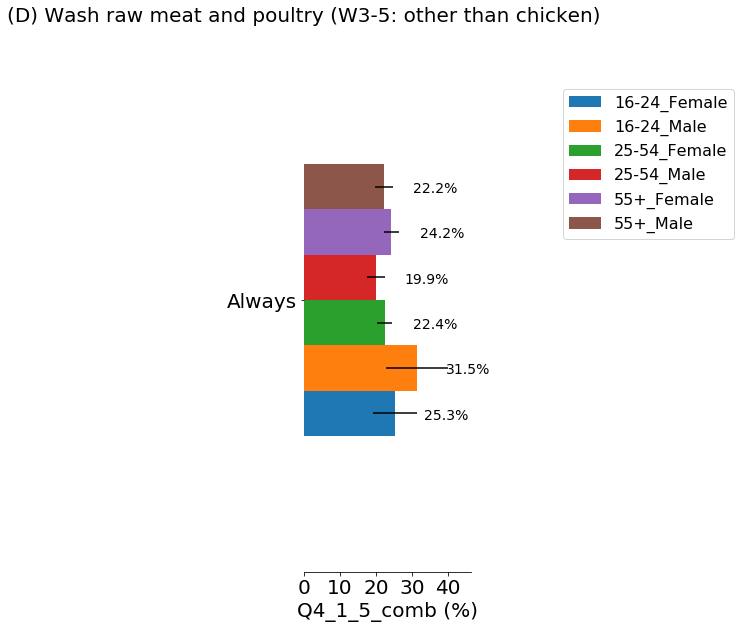

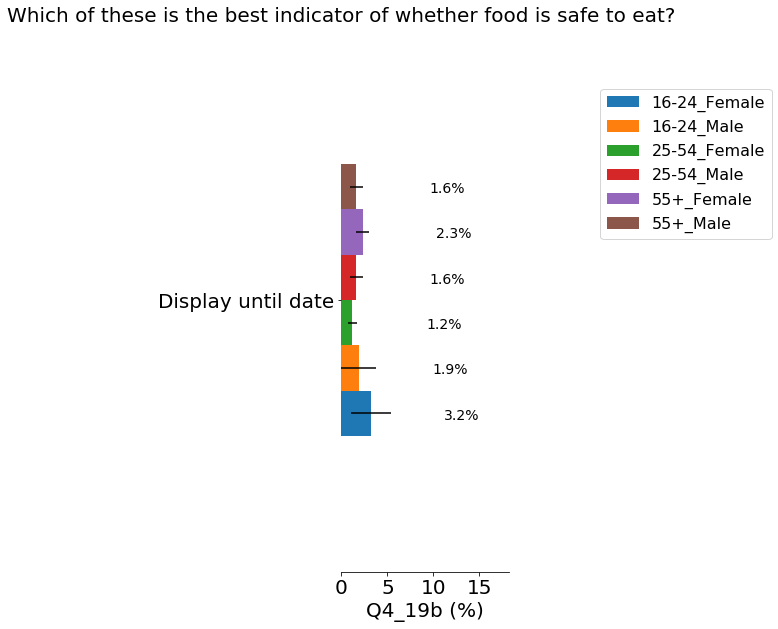

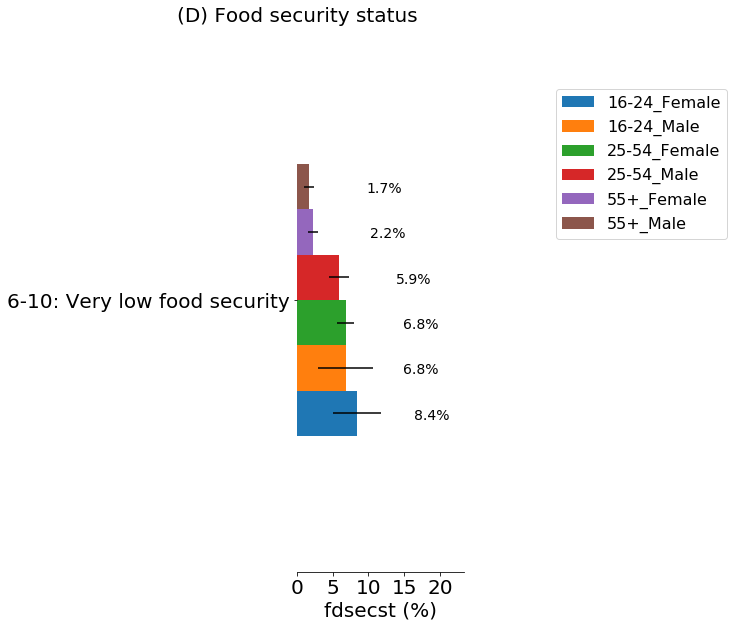

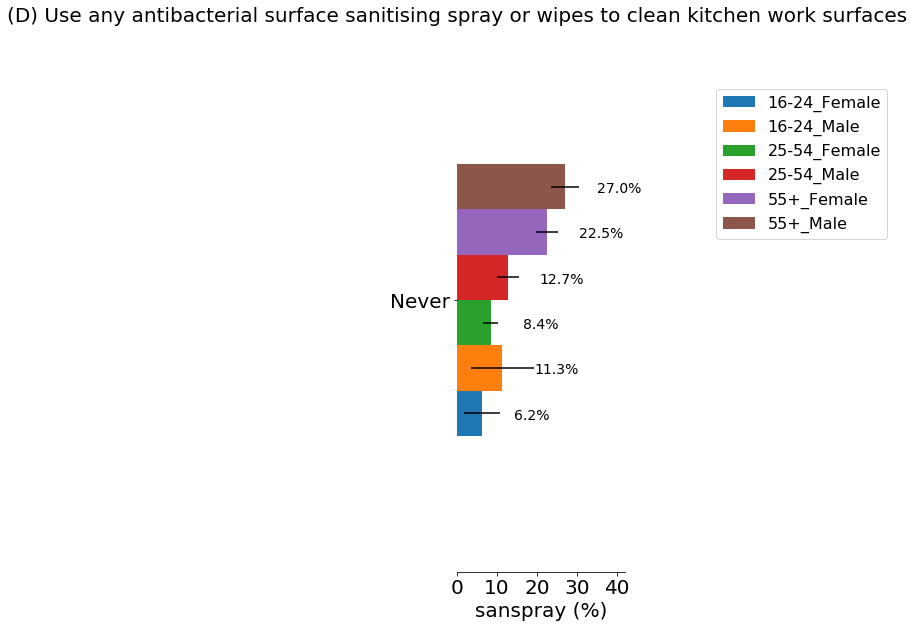

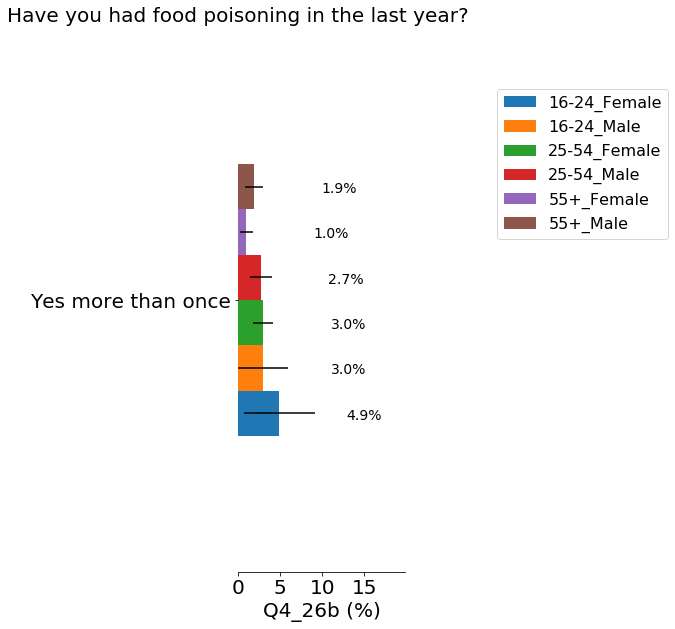

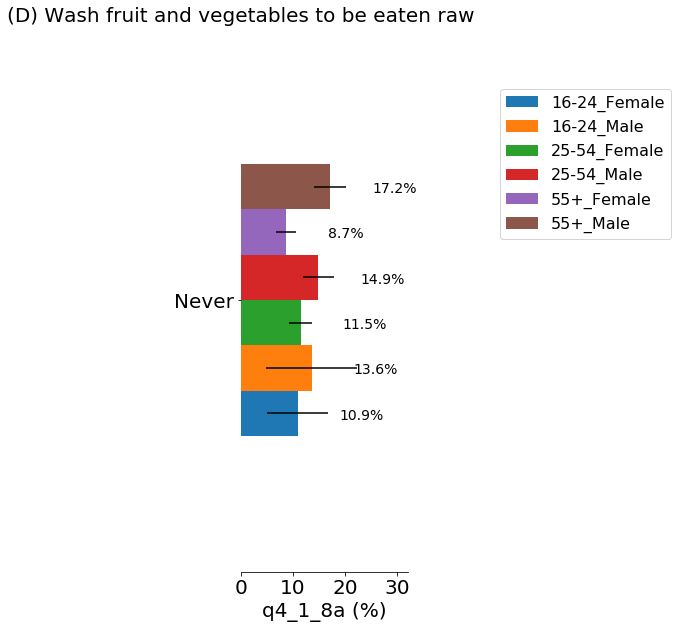

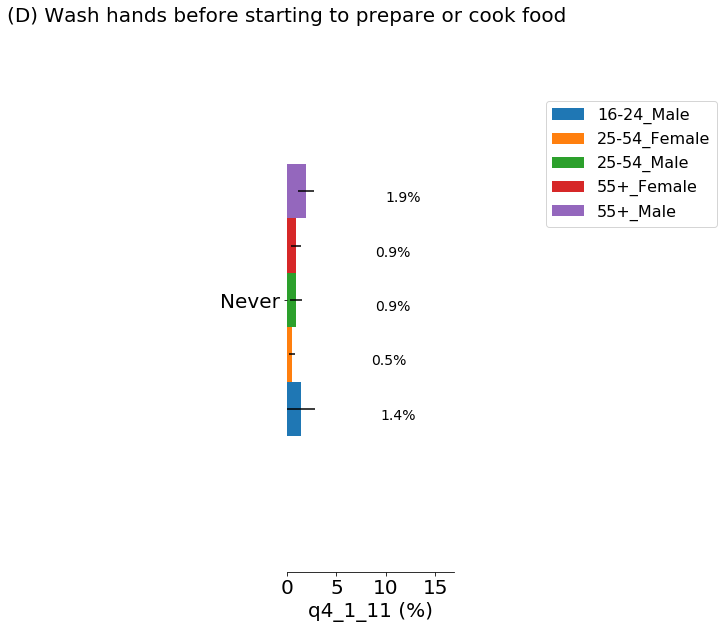

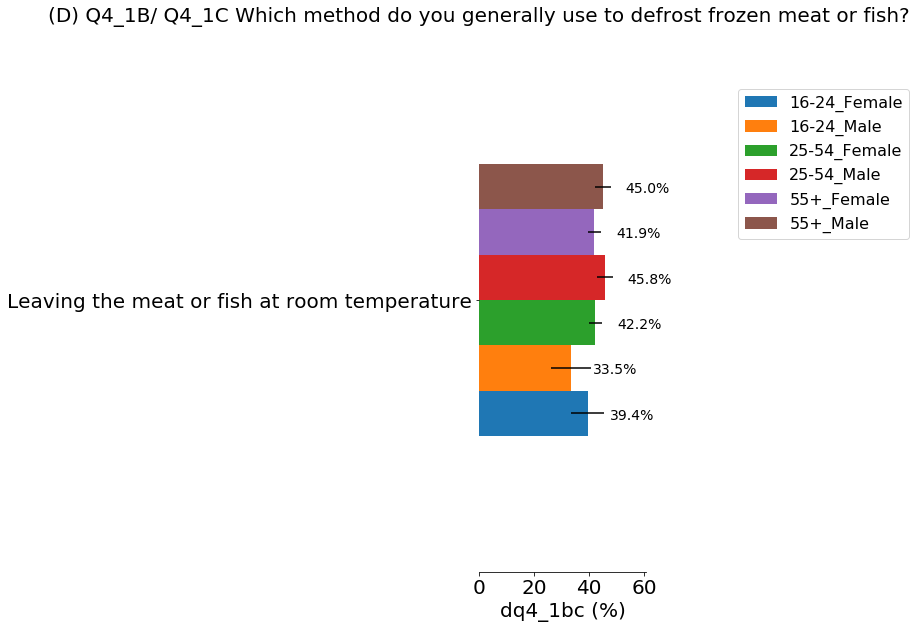

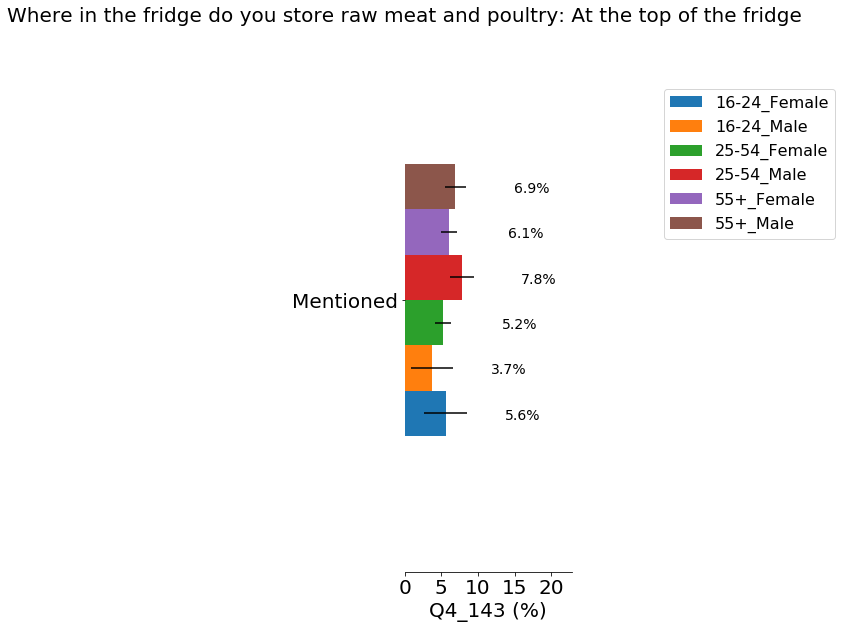

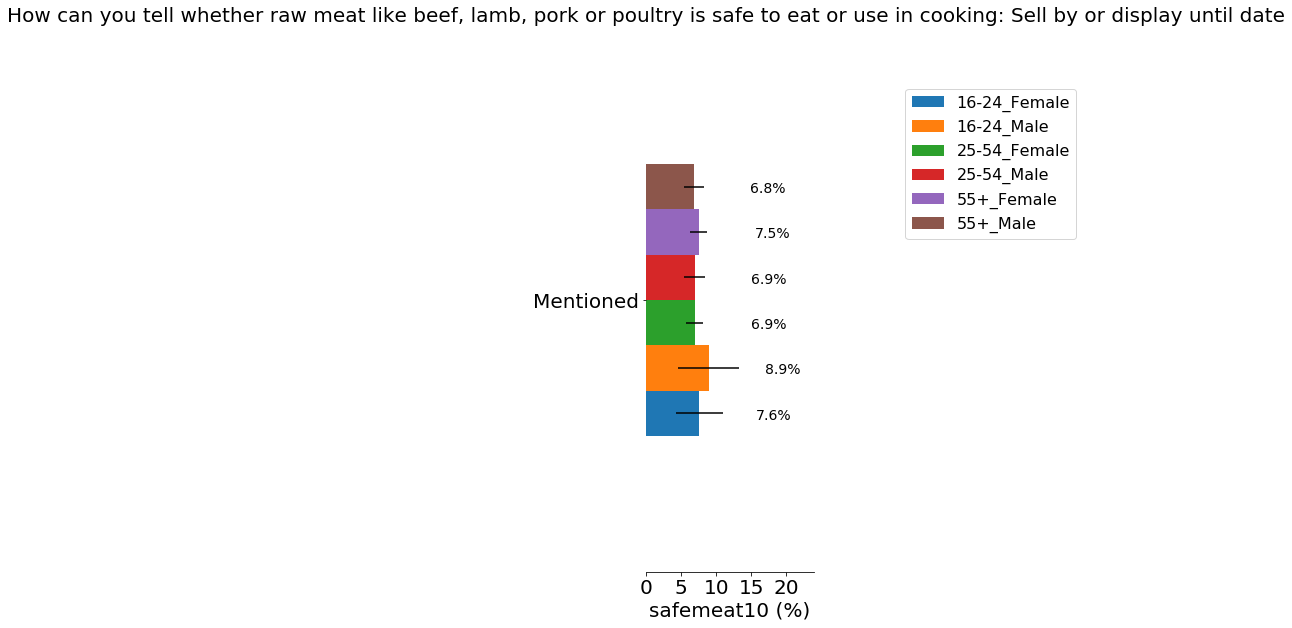

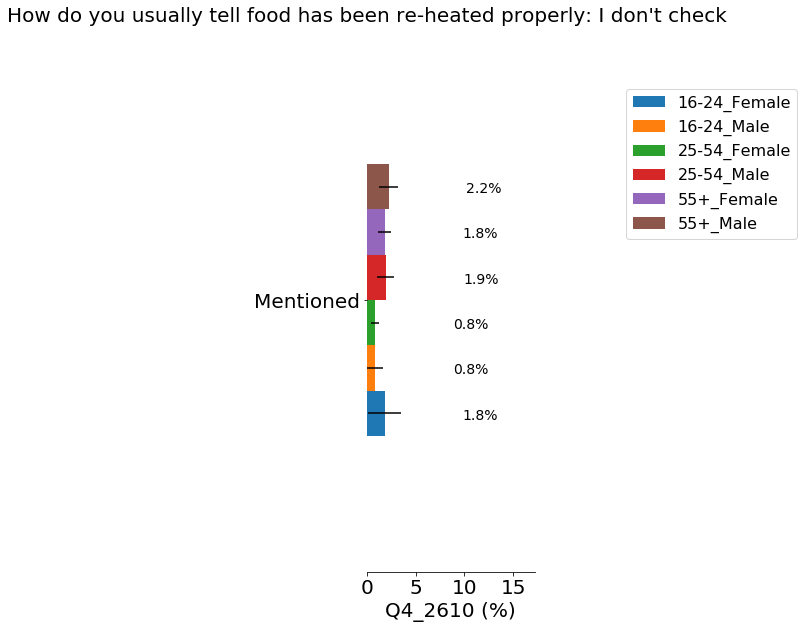

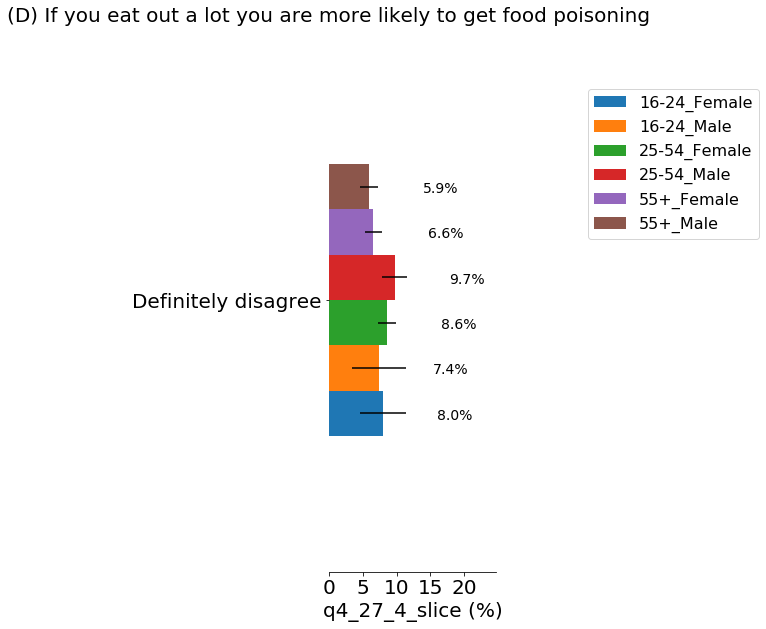

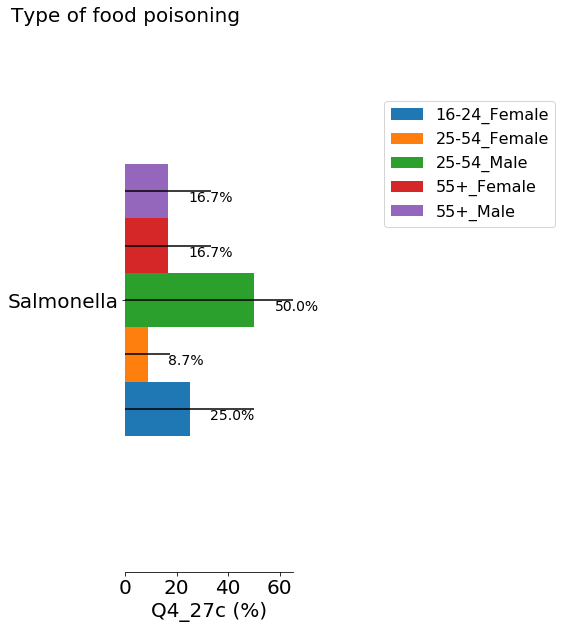

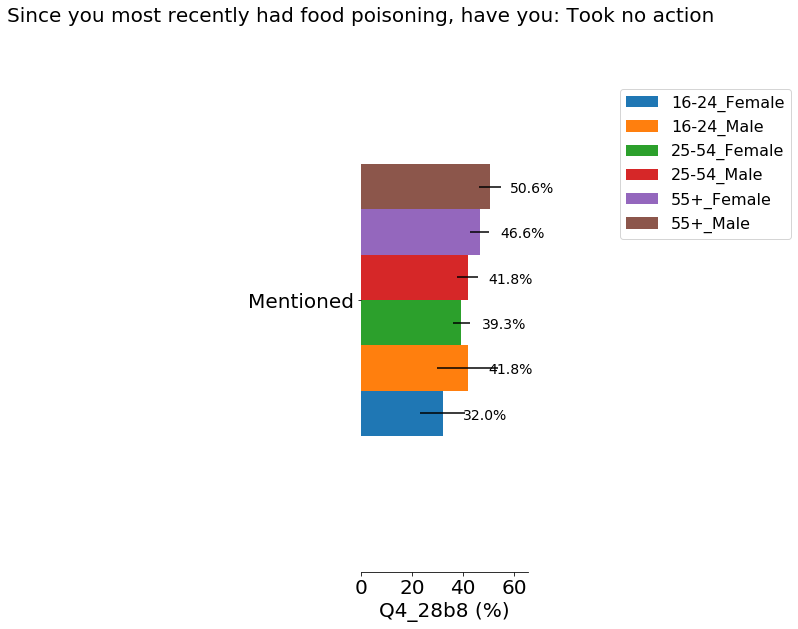

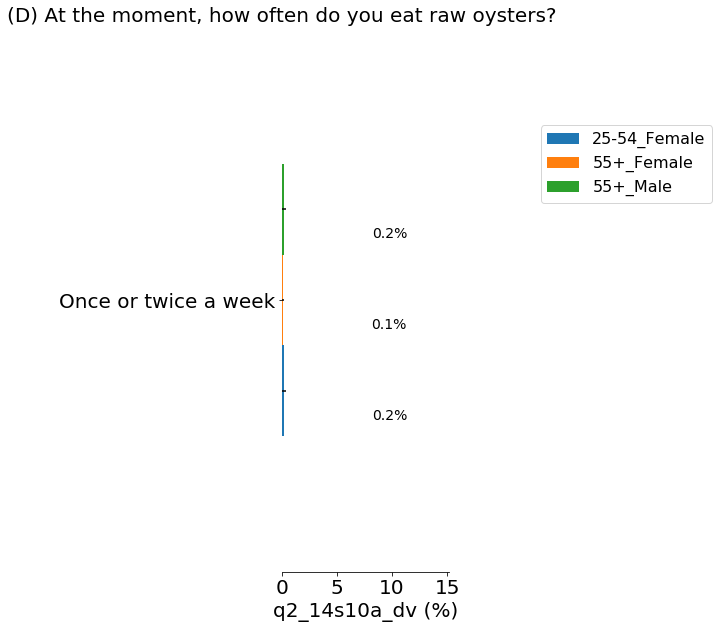

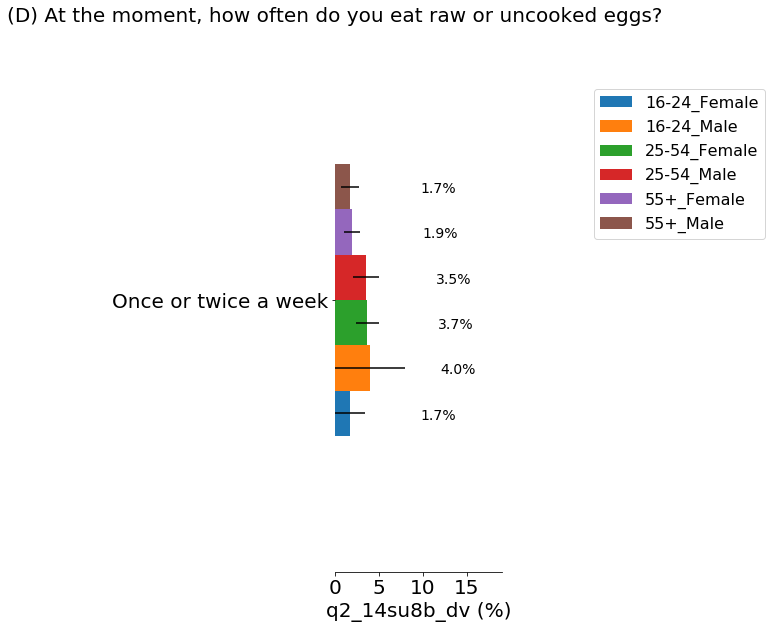

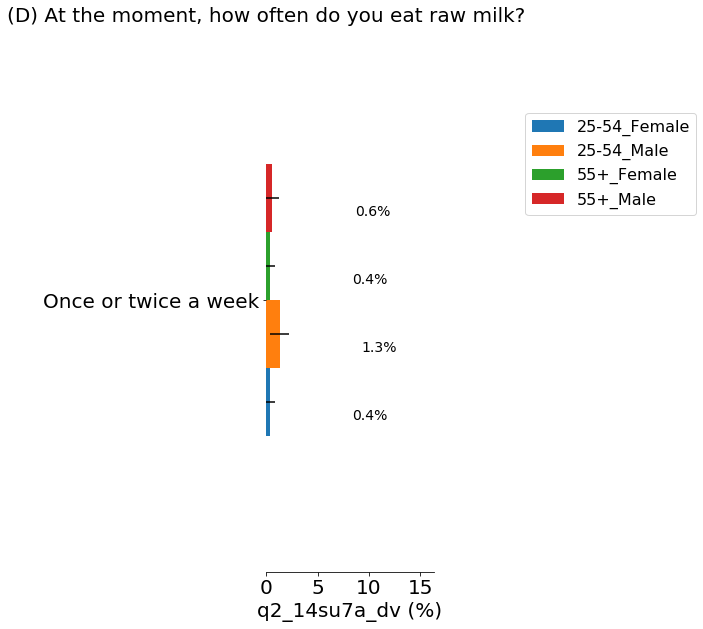

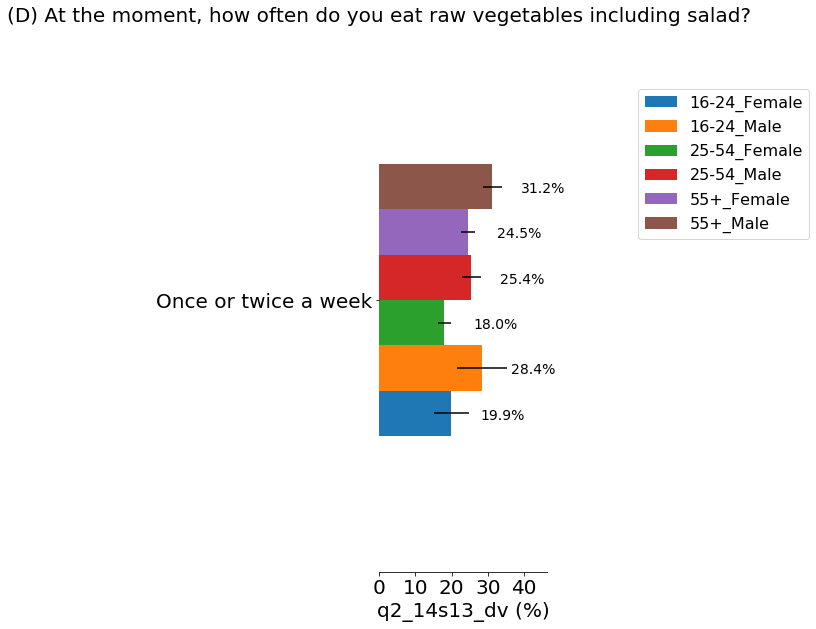

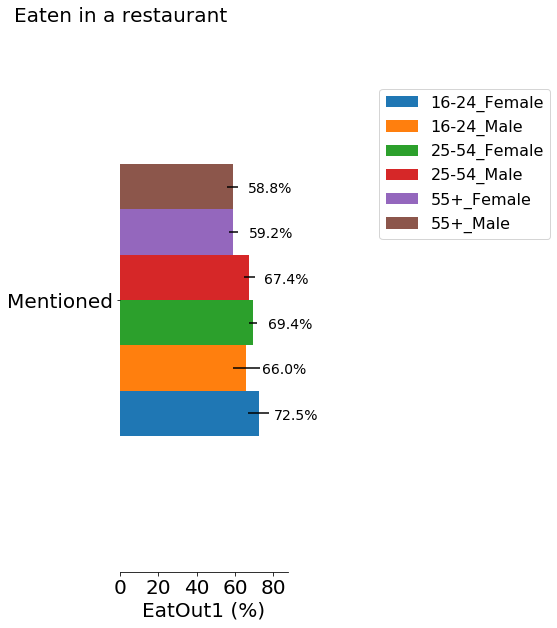

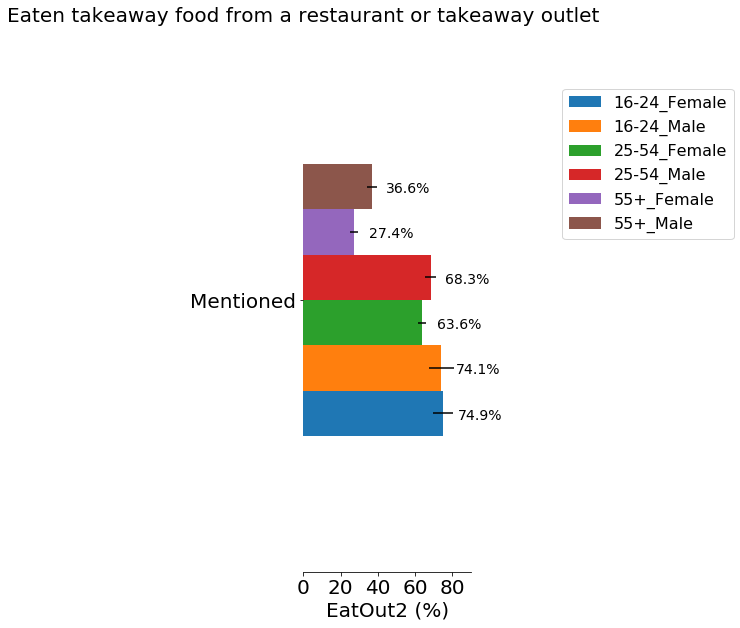

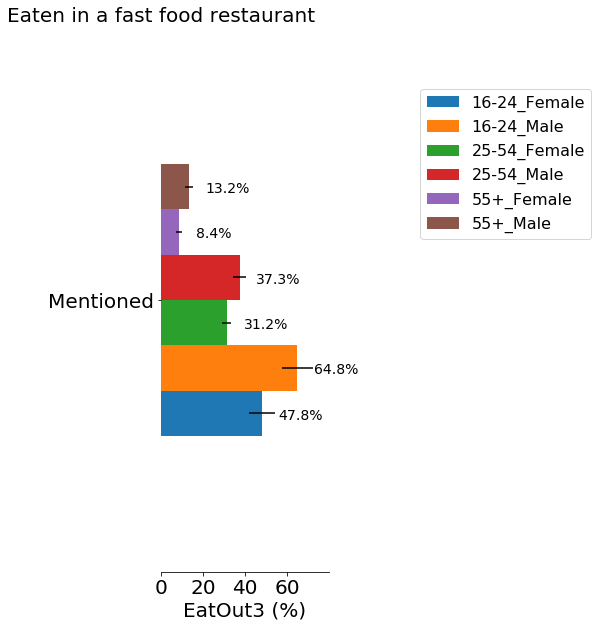

In [81]:
custom_barplots(survey_subpopulation,
                'combined_demographics',
                questions_of_interest,
                'foodBehaviour_highRisk_byDemographics.pdf',
                myspacingy=0.03, myspacingx=8, myfontsize=14,
                high_risk_option='yes')

# Interactive dashboard 

## To show this as an independent (local) dashboard with Voila 
(https://github.com/voila-dashboards/voila):
Install in terminal by: conda install -c conda-forge voila
Start Voilà locally (cd in directory with this notebook) by running: voila Food-and-You-survey_risks.ipynb

## To give access to voila dashboard remotely using github and binder:
Set up a public github repo with all data files needed (as csv),jupyter notebook with widgets(in which all csv files are read using the raw URLs from github)and a requirements.txt (listing  all the modules needed to run the notebook).

Use binder (https://mybinder.org) and specify the path of the jupypter notebook (using voila/render), indicate it is a URL path.

The new URL generated can be shared and is available any time.

## To give access to voila dashboard remotely using ngrok:

(see https://voila.readthedocs.io/en/stable/deploy.html#sharing-voila-applications-with-ngrok)

Install ngrok: https://ngrok.com/download, unzip file and, if using macOS, move executable file to /usr/local/bin

Start Voilà locally (cd in directory with this notebook) by running: voila Food-and-You-survey_risks.ipynb

In a new terminal window, start ngrok by running: ngrok http 8866 (check local host number actually used by the dashboard of interest, as, if running voila multiple times, this number will change)

Copy the link from the ngrok terminal window (link looks like https://8bb6fded.ngrok.io) and use or send link.

### To note

Website will take some time to load, as the jupyter noteook is running in the background.

When using the ngrok link, the requests will be forwared to your local instance of Voilà.

Census data is too heavy and cannot be ploted as a voila dashboard

### Plot food risks associated to desired subpopulation groups for specified relevant questions:


In [ ]:
country_dict = answers_dict['country_dv']
country_list = list(survey_subpopulation.country_dv.unique())
country_list[:] = [country_dict.get(e,'') for e in country_list]
country_dict_inv = {v: k for k, v in country_dict.items()}

region_dict = answers_dict['region_dv']
region_list = list(survey_subpopulation.region_dv.unique())
region_list[:] = [region_dict.get(e,'') for e in region_list]
region_dict_inv = {v: k for k, v in region_dict.items()}

questions_of_interest_names = questions_of_interest.copy()
questions_of_interest_names[:] = [questions_dict.get(e,'') for e in questions_of_interest_names]
questions_dict_inv = {v: k for k, v in questions_dict.items()}

risks_options = ['No', 'Yes']

demographics_list = ['Not applicable', 'Age (in detail)', 'Age', 'Gender', 'Marital status', 'Working status',
                     'Religion', 'Health', 'Urban-Rural classification', 'Household size',
                     'Household income', 'Children under 6 in household', 'Children under 16 in household']

demographic_dict = {'Not applicable':'dummy', 'Age (in detail)':'age_dv', 'Age':'age_dv_grouped', 'Gender':'RespSex',
                    'Marital status':'marstat2', 'Working status':'workstat2', 'Religion':'religion_dv',
                    'Health':'Q6_1', 'Urban-Rural classification':'UrbanRuralInd',
                    'Household size':'bhhsize2', 'Household income':'hhdinc',
                    'Children under 6 in household':'below6', 'Children under 16 in household':'below16'}

### Whole UK

In [ ]:
@interact
def plot(question=questions_of_interest_names,
         risk_only=risks_options,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    
    if risk_only == 'No':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)])        
        custom_barplots(survey_subpopulation,
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        interactivity='yes', barwidth=0.9)
        
    if risk_only == 'Yes':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)]) 
        custom_barplots(survey_subpopulation,
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        high_risk_option='yes', interactivity='yes', barwidth=0.9)

### Per country

In [ ]:
@interact
def plot(country=country_list,
         question=questions_of_interest_names,
         risk_only=risks_options,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    
    if risk_only == 'No':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)])        
        custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(country_dict_inv.get(country))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        interactivity='yes', barwidth=0.9)
        
    if risk_only == 'Yes':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)]) 
        custom_barplots(survey_subpopulation[survey_subpopulation.country_dv.eq(country_dict_inv.get(country))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        high_risk_option='yes', interactivity='yes', barwidth=0.9)

### Per region

In [ ]:
@interact
def plot(region=region_list,
         question=questions_of_interest_names,
         risk_only=risks_options,
         demographics1=demographics_list,
         demographics2=demographics_list,
         demographics3=demographics_list):
    
    survey_subpopulation['dummy']=''
    
    if risk_only == 'No':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)])        
        custom_barplots(survey_subpopulation[survey_subpopulation.region_dv.eq(region_dict_inv.get(region))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        interactivity='yes', barwidth=0.9)
        
    if risk_only == 'Yes':
        survey_subpopulation['combined_demographics']=(survey_subpopulation[demographic_dict.get(demographics1)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics2)]+' '+
                                                       survey_subpopulation[demographic_dict.get(demographics3)]) 
        custom_barplots(survey_subpopulation[survey_subpopulation.region_dv.eq(region_dict_inv.get(region))],
                        'combined_demographics',
                        [questions_dict_inv.get(question)],
                        myspacingy=0.03, myspacingx=15,
                        high_risk_option='yes', interactivity='yes', barwidth=0.9)

In [99]:
# Remove variables which have a variance threshold less than 0.5 
# Followed this example https://stackabuse.com/applying-filter-methods-in-python-for-feature-selection/
# chi-squared statistic is better suited for feature selection in categorical data
# Mishka Nemes - 19/04/2020


from sklearn.feature_selection import VarianceThreshold

# Create VarianceThreshold object with a variance with a threshold of 0.5 i.e. where 95% of values are similar 
thresholder = VarianceThreshold(threshold=.1)

# Conduct variance thresholding
survey_high_variance = thresholder.fit(survey_full_dataset)

# See all the columns that have a vairance threshold higher than 0.5

high_var_cols = [column for column in survey_full_dataset.columns
                    if column not in survey_full_dataset.columns[survey_high_variance.get_support()]]


# print(len(high_var_cols))

for column in high_var_cols:
    print(column)

resfdprp
bcook3
dietary
reaccoe
reacnoc
reacglu
reaclac
reaccow
reacfpi
Q2_19
EatOut10
EatOut11
eatoutev
EatOutInfDV_Nw
EatOutInfDV_WG
EatOutInfDV_TV
EatOutInfDV_Bk
EatOutInfDV_Ad
EatOutInfDV_Oth
EatOutInfDV_None
Q2_35DV_Ca
Q2_35DV_Al
Q2_35DV_None
Q2_35DV_Oth
Q2_38DV7
resfdshp
Q3_31
Q3_34
Q3_38
Q3_310
Q3_311
Q3_312
Q3_313
Q3_1310
Q3_1311
Q4_1b1
Q4_1b6
q4_1b7
Q4_1b5
Q4_32
Q4_34
Q4_35
Q4_39
Q4_310
Q4_311
Q4_312
Q4_8a
Q4_8c5
Q4_8c6
Q4_8c7
Q4_8c8
Q4_8c9
Q4_8c9a
Q4_8c10
Q4_114
Q4_116
Q4_117
Q4_141
Q4_143
Q4_144
Q4_145
Q4_146
Q4_147
Q4_148
Q4_1410
Q4_149
q4_1411
Q4_156
q4_157
safemeat4
safemeat5
safemeat6
safemeat8
safemeat10
safemeat11
safemeat12
safemeat13
safemeat14
safedairy2
safedairy5
safedairy6
safedairy8
safedairy10
safedairy11
safedairy12
safedairy13
safedairy14
safecheese4
safecheese5
safecheese6
safecheese8
safecheese10
safecheese11
safecheese12
safecheese13
safecheese14
safeegg2
safeegg4
safeegg5
safeegg6
safeegg10
safeegg11
safeegg12
safeegg13
safeegg14
safefish4
safefish5
safef